# 🤒 Epidemic mitigation project - solution notebook

In [89]:
import random
import torch
import pickle

import torch.nn             as nn
import torch.optim          as optim
import numpy                as np
import matplotlib.pyplot    as plt

from IPython.display        import clear_output
from torch                  import Tensor
from gym                    import spaces

from matplotlib.patches     import Patch
from matplotlib.figure      import Figure
from matplotlib.axes        import Axes
from matplotlib.ticker      import MultipleLocator

from tqdm.notebook          import tqdm
from collections            import namedtuple, deque
from typing                 import List, Dict, Tuple, Any

"""Environment imports"""
from epidemic_env.env       import Env
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.agent     import Agent

EVALUATION_DICT = {}

## 1. Introduction

### Question 1.a) study the behavior of the model when the epidemics are unmitigated

First we define the plotting function :

In [90]:
%matplotlib inline
def plot_episode(total, cities, actions=None):
    fig = plt.figure(figsize=(18,10))
    if actions:
        ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
        ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    else:
        ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=5)
        ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(5, 0), rowspan=4)
        
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')
    if actions:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

Then we play through a full epidemic episode as follows:

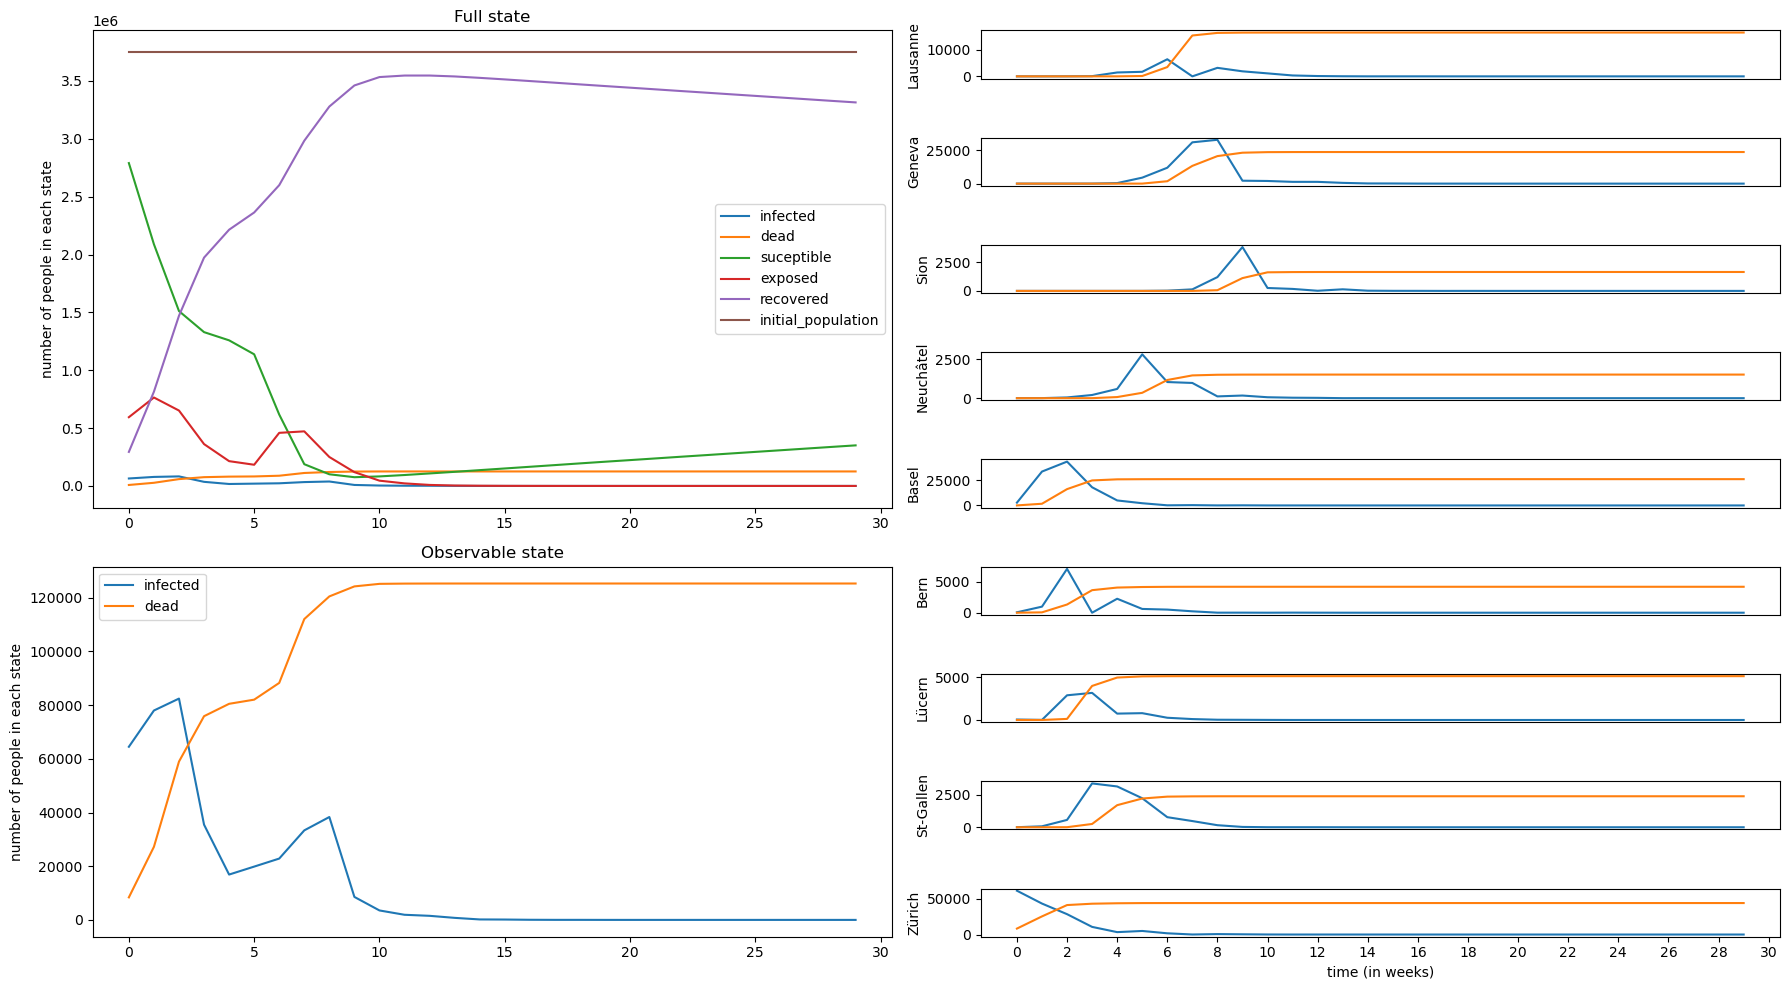

In [91]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment"""
env = Env(dyn)

action = action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
plot_episode(total, cities)

## 2. Professor Russo's Policy

### Question 2.a) implement Pr. Russo's Policy

In [77]:
class Russo(Agent):
    def __init__(self,  env:Env,
                 threshold:int=20000,
                 confine_time:int=4,):
        """Naive Agent implementation. Gives a baseline to compare reinforcement learning agent_dec_eps_dec_epss against. 
        The naive policy is the following:
        ```pseudocode
        If number of infected people > THRESHOLD
            confine the entire country for CONFINEMENT_TIME weeks
        ```

        Args:
            env (_type_): the simulation environment.
            threshold (int, optional): The infected threshold, upon which confiment must start. Defaults to 20000.
            confine_time (int, optional): The confinement time. Defaults to 4.
        """

        self.env = env
        self.threshold = threshold
        self.confine_time = confine_time
        self.timer = 0
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
        #This is agent is born stupid and stays stupid
        return 0
    
    def reset(self,):
        self.timer = 0

    def act(self, obs):
        if self.timer > 0:
            self.timer -=1
            return 1, 0
        if obs > self.threshold:
            self.timer = self.confine_time
            return 1, 0
        return 0,0

In [78]:
def russo_act_pre(a, dyn:ModelDynamics):
    return {
        'confinement': a==1,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }

def russo_obs_pre(obs:Observation, dyn:ModelDynamics):
    return obs.total.infected[-1]

#### Running and plotting a single episode

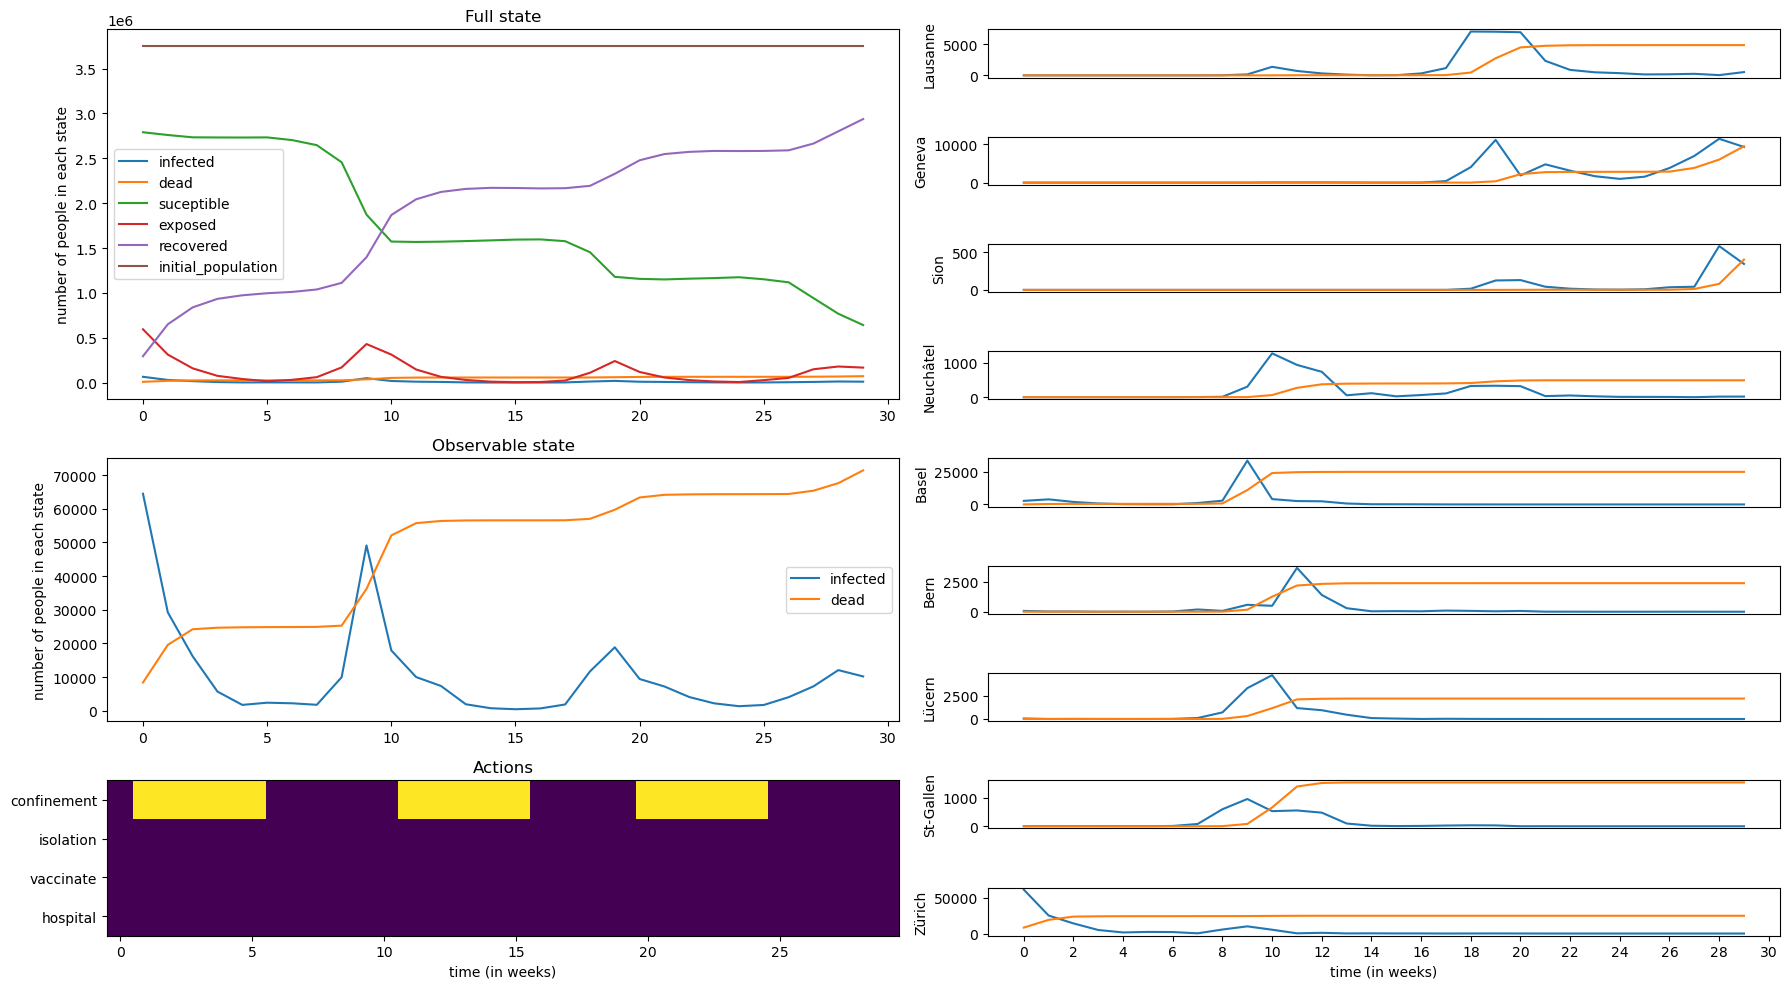

In [92]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_preprocessor=russo_act_pre,
            observation_preprocessor=russo_obs_pre)
agent = Russo(env) # defined above

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
while not finished:
    action, _ = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

plot_episode(total,cities,actions)

### Question 2.b) evaluate Pr. Russo's Policy

Defining the generic evaluation procedure

In [79]:
def evaluate(env, agent, eval_iterations = 50, pbar=True):
    logs = []; rewards = []
    agent.epsilon = 0
    _range = range(eval_iterations)
    if pbar: _range = tqdm(_range,desc='Eval iteration')
    for eval_iter in _range:
        """ Run an episode """
        finished = False
        log = []; R_cum = 0;
        obs, info = env.reset(seed=eval_iter)
        agent.reset()
        while not finished:
            action, est_Q = agent.act(obs)
            obs, R, finished, info = env.step(action)
            log.append(info); R_cum += R
            if finished:
                break
            
        """ Parse the logs as they are generated """
        log = {
            'total': {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters},
            'cities': {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities},
            'actions': {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()},
        } 
        logs.append(log)
        rewards.append(R_cum)
    return logs, np.array([float(r) for r in rewards])

Running the evaluation

In [133]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_preprocessor=russo_act_pre,
            observation_preprocessor=russo_obs_pre)
agent = Russo(env) # defined above

""" Run the evaluation """
logs, rewards = evaluate(env,agent)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])
isol_days = np.array([np.sum(np.array(l['actions']['isolation']).astype(np.uint8))*7 for l in logs])
vaccination_days = np.array([np.sum(np.array(l['actions']['vaccinate']).astype(np.uint8))*7 for l in logs])
hosp_days = np.array([np.sum(np.array(l['actions']['hospital']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

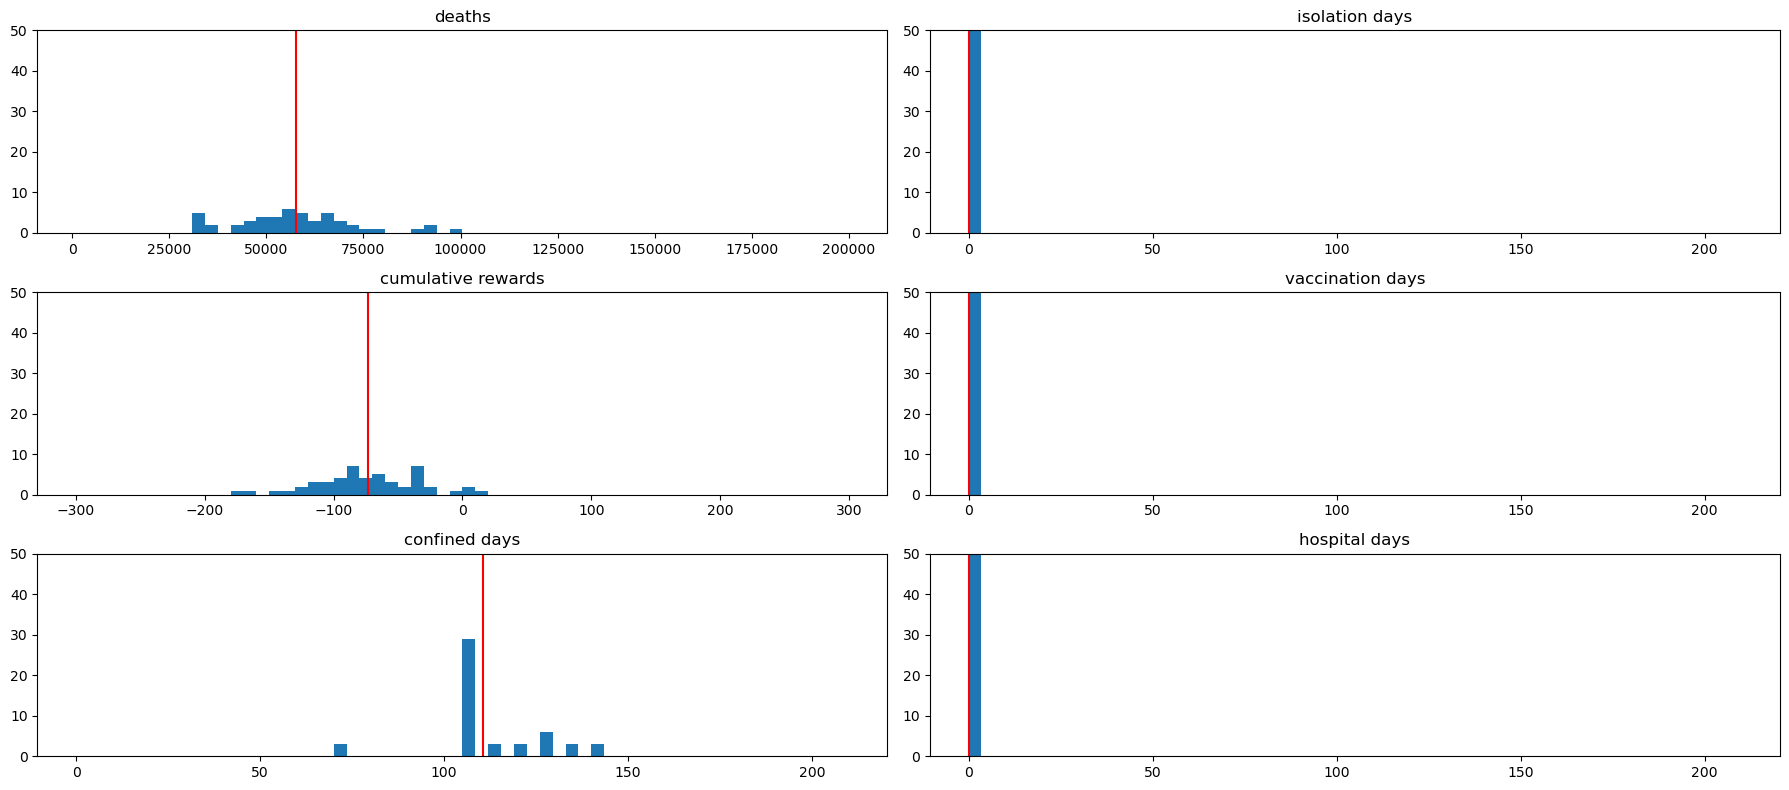

Average death number: 57749.34
Average cumulative reward: -73.27004531860352
Average number of confinement days: 110.46
Average number of isolation days: 0.0
Average number of vaccination days: 0.0
Average number of additional hospital days: 0.0


In [134]:
""" Plotting the results """
fig, ax = plt.subplots(3,2,figsize=(18,8))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0,0], deaths,'deaths',(1000,200000),50)
hist_avg(ax[1,0], rewards,'cumulative rewards',(-300,300),50)
hist_avg(ax[2,0], conf_days,'confined days',(0,210),50)
hist_avg(ax[0,1], isol_days,'isolation days',(0,210),50)
hist_avg(ax[1,1], vaccination_days,'vaccination days',(0,210),50)
hist_avg(ax[2,1], hosp_days,'hospital days',(0,210),50)
fig.tight_layout()
plt.show()

""" Saving the results """
EVALUATION_DICT['Russo'] = {
    'deaths' : np.mean(deaths),
    'confinement' : np.mean(conf_days),
    'isolation' : np.mean(isol_days),
    'vaccination' : np.mean(vaccination_days),
    'hospital' : np.mean(hosp_days),
    'rewards' : np.mean(rewards),
}

""" Printing the results """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confinement days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(isol_days)}')
print(f'Average number of vaccination days: {np.mean(vaccination_days)}')
print(f'Average number of additional hospital days: {np.mean(hosp_days)}')

## 3. A Deep-Q-learning approach

### Question 3.a) implementing Deep Q-Learning

#### Action / Observation Preprocessors

In [82]:
SCALE = 100 # Scaling is a bit rough but whatever is fine I think

def binary_act_pre(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action()
    action['confinement'] = (a == 1)
    return action
    
def naive_obs_pre(obs:Observation, dyn:ModelDynamics):
    infected = SCALE * \
        np.array([np.array(obs.city[c].infected) /
                    obs.pop[c] for c in dyn.cities])
    dead = SCALE * \
        np.array([np.array(obs.city[c].dead)/obs.pop[c]
                    for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

#### Deep Q-learning agent class

In [83]:
"""Simple DQN implementaiton 
(closely matches the implementation style from the pytorch tutorial : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#replay-memory)
"""

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    """ Useful replay memory class """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQNAgent(Agent):
    """ Deep-Q-Learning agent implementation """
    def __init__(self,  env:Env,
                 model:torch.nn,
                 criterion=nn.HuberLoss(),
                 lr:float=1e-3,
                 epsilon:float=0.5,
                 gamma:float=0.99,
                 buffer_size:int=10000,
                 batch_size:int=64)->None:

        self.env = env
        model_params = {
            'in_dim': len(env.observation_space.sample().flatten()),
            'out_dim': env.action_space.n,
        }
        self.model = model(**model_params)
        self.targetModel = model(**model_params)

        self.criterion = criterion

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.memory = ReplayMemory(buffer_size)
        self.batch_size = batch_size

        self.epsilon = epsilon
        self.gamma = gamma
        self.lr = lr

    def load_model(self, savepath):
        torch.save(self.model.state_dict(), savepath)
        self.model.load_state_dict(torch.load(savepath))

    def save_model(self, savepath):
        torch.save(self.model.state_dict(), savepath)

    def optimize_model(self): 
        """ Implements a training step """
        if len(self.memory) < self.batch_size:
            return np.double(0) # Do nothing if not enough samples

        """ Sampling memory and batch construction"""
        transitions = self.memory.sample(self.batch_size)
        # Convert Batch(Transitions) -> Transition(Batch)
        batch = Transition(*zip(*transitions))
        action_batch = torch.tensor([e for e in batch.action])
        state_batch = torch.cat(batch.state, 0)
        next_states_batch = torch.cat(batch.next_state, 0)
        reward_batch = torch.cat(batch.reward)

        """ Loss computation """
        state_action_values = self.model( # Compute Q(S, a) with the Q-value network
            state_batch).gather(1, action_batch.unsqueeze(1))
        
        next_state_values = self.targetModel(next_states_batch).max(1)[
            0].detach().unsqueeze(1) # Compute max_ap Q(Sp) with the stable target network
        expected_state_action_values = ( # Compute the expected Q values
            next_state_values * self.gamma) + reward_batch


        loss = self.criterion(state_action_values,  # Compute the loss
                              expected_state_action_values)

        """ One gradient descent step """
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return np.double(loss)

    def act(self, obs:np.ndarray):
        """ Actions from observations """
        x = torch.Tensor(obs)
        Q_est = self.model(x)
        
        if random.random() > self.epsilon:
            with torch.no_grad():
                return np.argmax(Q_est), Q_est.detach()
        else:
            act = self.env.action_space.sample()
            return act, Q_est.detach()[0]
    
    def reset(self,):
        pass # Not stateful

#### Building the neural network

In [84]:
class DQN(nn.Module):
    """Fully connected Q-Value estimator network."""
    def __init__(self, in_dim:int=126, out_dim:int=16)-> nn.Module:
        super().__init__()
        
        lin_layers = []
        lin1 = nn.Linear(in_features=in_dim, out_features=64)
        relu1 = nn.ReLU()
        lin_layers += [lin1, relu1]
        lin2 = nn.Linear(in_features=64, out_features=32)
        relu2 = nn.ReLU()
        lin_layers += [lin2, relu2]
        lin3 = nn.Linear(in_features=32, out_features=16)
        relu3 = nn.ReLU()
        lin_layers += [lin3, relu3]
        lin4 = nn.Linear(in_features=16, out_features=out_dim)
        lin_layers += [lin4]

        self.fcn = nn.Sequential(*lin_layers)

    def forward(self, x:Tensor) -> Tensor:
        x = self.fcn(x.view(x.size(0), -1))
        return x

#### Training the agent

In [31]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )

RUN_NAME = 'deep_q_learning'
RESULTS_FOLDER = 'results/'
MODEL_FOLDER = 'models/'
NUM_EPISODES = 500
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 10
EPSILON = 0.7
NUM_TRACES = 3
EPSILON = 0.7
LR=5e-3
GAMMA = 0.9
BF_SIZE = 20000
BATCH_SIZE = 512


In [32]:

max_reward = -1e10
traces = []
for seed in range(NUM_TRACES):
    """Ensure deterministic training"""
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    
    """Initialize new agent (one per trace, different seed)"""
    agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = LR,
                    epsilon = EPSILON,
                    gamma = GAMMA,
                    buffer_size=BF_SIZE,
                    batch_size=BATCH_SIZE)
    
    rlog_training = []
    rlog_eval = []
    x_eval = []
    for episode in tqdm(range(NUM_EPISODES)):
        if episode % TARGET_UPDATE_RATE == 0:
            agent.targetModel.load_state_dict(agent.model.state_dict())

        finished = False
        obs, info = env.reset((1+seed)*episode) #ensure that each run is uniquely seeded
        agent.reset()
        agent.epsilon = EPSILON
        
        R_cum = 0
        while not finished:
            action, est_Q = agent.act(obs)
            obs_next, R, finished, info = env.step(action)
            agent.memory.push(obs, action, obs_next, R)
            loss = agent.optimize_model()
            obs = obs_next; R_cum += R
            if finished:
                break
        rlog_training.append(R_cum)
        if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
            agent.epsilon = 0 # evaluation runs are performed with epsilon = 0
            _, rewards = evaluate(env, agent, eval_iterations = EVAL_SAMPLES,pbar=False)
            R_eval = np.mean(rewards)
            rlog_eval.append(R_eval); x_eval.append(episode)
            print( f"Evaluated cumulative reward R={R_eval}.")
            
            if R_eval > max_reward:
                max_reward = R_eval; print( f"    New maximum reward, saving weights!")
                torch.save(agent.model, MODEL_FOLDER + RUN_NAME + '.pkl')
                
    traces += [{
        'run_name': 'fixed epsilon',
        'x_eval': x_eval,
        'rlog_eval': rlog_eval,
        'rlog_training': rlog_training,
    }]
    
RESULTS_FOLDER = 'results/'
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(traces,file)

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-148.73327178955077.
    New maximum reward, saving weights!
Evaluated cumulative reward R=29.60819001197815.
    New maximum reward, saving weights!
Evaluated cumulative reward R=25.06480555534363.
Evaluated cumulative reward R=15.163377118110656.
Evaluated cumulative reward R=22.960224556922913.
Evaluated cumulative reward R=19.854799938201904.
Evaluated cumulative reward R=11.132978975772858.
Evaluated cumulative reward R=22.413481760025025.
Evaluated cumulative reward R=32.82066774368286.
    New maximum reward, saving weights!
Evaluated cumulative reward R=31.597236824035644.
Evaluated cumulative reward R=24.965355396270752.


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-148.73327178955077.
Evaluated cumulative reward R=25.823956346511842.
Evaluated cumulative reward R=24.485672903060912.
Evaluated cumulative reward R=29.354968070983887.
Evaluated cumulative reward R=26.51696710586548.
Evaluated cumulative reward R=19.649625730514526.
Evaluated cumulative reward R=27.191951990127563.
Evaluated cumulative reward R=25.376182556152344.
Evaluated cumulative reward R=28.244705843925477.
Evaluated cumulative reward R=31.59495601654053.
Evaluated cumulative reward R=29.079635322093964.


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-148.73327178955077.
Evaluated cumulative reward R=25.80688843727112.
Evaluated cumulative reward R=27.63336992263794.
Evaluated cumulative reward R=24.373680973052977.
Evaluated cumulative reward R=9.009371352195739.
Evaluated cumulative reward R=16.366597068309783.
Evaluated cumulative reward R=8.391375041007995.
Evaluated cumulative reward R=17.895781683921815.
Evaluated cumulative reward R=23.031870913505553.
Evaluated cumulative reward R=22.626946663856508.
Evaluated cumulative reward R=12.677233862876893.


#### Plotting the training curve

/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.concatenate([np.array(n['rlog_training']) for n in nr]),4)
/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.concatenate([np.array(n['rlog_training']) for n

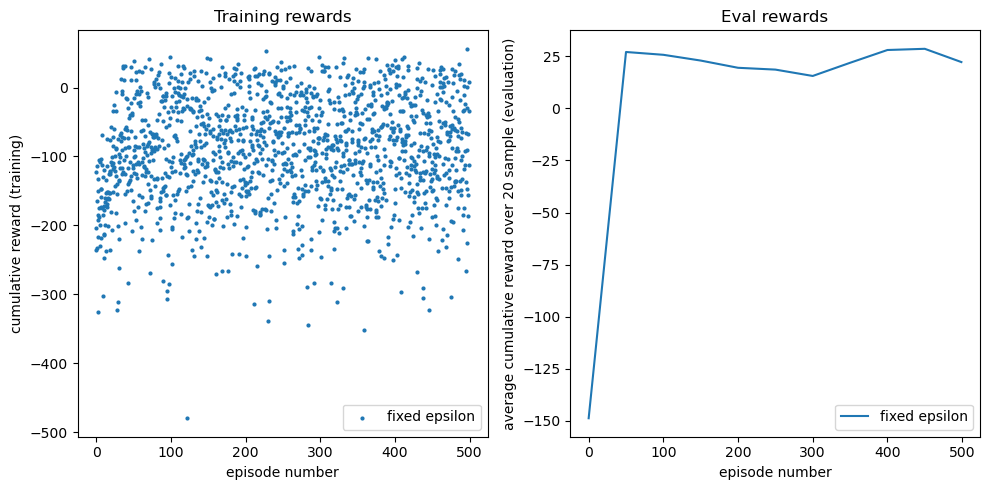

In [85]:
def plot_training_curves(numerical_results):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    for nr in numerical_results:
        ax[0].scatter(np.concatenate([list(range(len(n['rlog_training']))) for n in nr]),
                      np.concatenate([np.array(n['rlog_training']) for n in nr]),4)
        ax[0].set_title('Training rewards')
        ax[0].set_ylabel('cumulative reward (training)')
        ax[0].set_xlabel('episode number')
        ax[1].plot(nr[0]['x_eval'], np.mean([n['rlog_eval'] for n in nr],0))
        ax[1].set_ylabel('average cumulative reward over 20 sample (evaluation)')
        ax[1].set_xlabel('episode number')
        ax[1].set_title('Eval rewards')
    ax[0].legend([nr[0]['run_name'] for nr in numerical_results])
    ax[1].legend([nr[0]['run_name'] for nr in numerical_results])
    fig.tight_layout()

with open(RESULTS_FOLDER + 'deep_q_learning.pkl', 'rb') as file:
    training_curves =  pickle.load(file)
plot_training_curves([training_curves])

#### Running and plotting an example episode

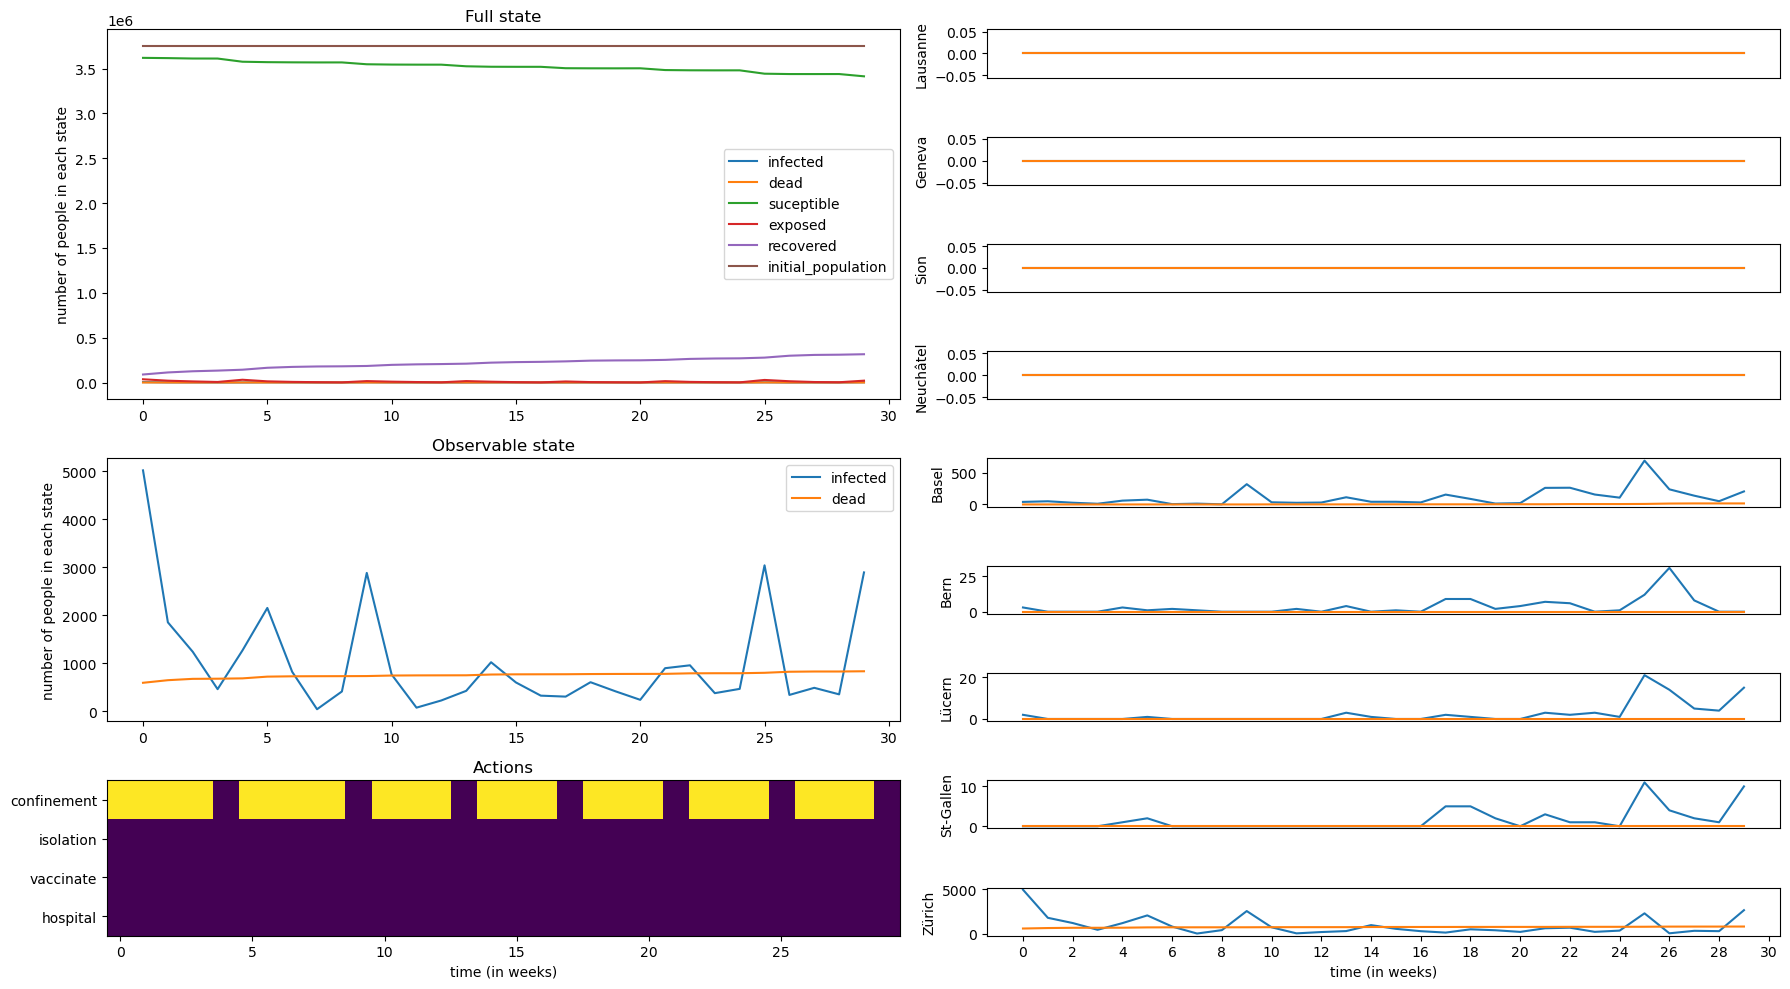

In [93]:

dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = LR,
                    epsilon = EPSILON,
                    gamma = GAMMA,
                    buffer_size=BF_SIZE,
                    batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning.pkl')

""" Run the simulation """
log = []
qvals = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action, q = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info);qvals.append(q) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

plot_episode(total,cities,actions)

### Question 3.b) Decreasing exploration

In [35]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )


RUN_NAME = 'deep_q_learning_dec_epsilon'
MODEL_FOLDER = 'models/'
RESULTS_FOLDER = 'results/'
NUM_EPISODES = 500
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 10
NUM_TRACES = 3
EPSILON = 0.7
LR=5e-3
GAMMA = 0.9
BF_SIZE = 20000
BATCH_SIZE = 512
EPSILON_0 = 0.7
EPSILON_MIN = 0.2
T_MAX = 500
NUM_TRACES = 3

#### Implementing the training loop

In [36]:
max_reward = -1e10
traces = []
for seed in range(NUM_TRACES):
    """Ensure deterministic training (one per trace, different seed)"""
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

    """Initialize the agent"""
    agent_dec_eps = DQNAgent(   env = env,
                        model = DQN,
                        criterion = nn.HuberLoss(),
                        lr = LR,
                        epsilon = EPSILON_0,
                        gamma = GAMMA,
                        buffer_size=BF_SIZE,
                        batch_size=BATCH_SIZE)
    
    rlog_training = []
    rlog_eval = []
    x_eval = []
    for episode in tqdm(range(NUM_EPISODES)):
        if episode % TARGET_UPDATE_RATE == 0:
            agent_dec_eps.targetModel.load_state_dict(agent_dec_eps.model.state_dict())

        finished = False
        obs, info = env.reset((1+seed)*episode) #ensure that each run is uniquely seeded
        agent_dec_eps.reset()
        agent_dec_eps.epsilon = max([EPSILON_0*(T_MAX-episode)/T_MAX,
                            EPSILON_MIN])
        
        R_cum = 0
        while not finished:
            action, est_Q = agent_dec_eps.act(obs)
            obs_next, R, finished, info = env.step(action)
            agent_dec_eps.memory.push(obs, action, obs_next, R)
            loss = agent_dec_eps.optimize_model()
            obs = obs_next; R_cum += R
            if finished:
                break
        rlog_training.append(R_cum)
        if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
            agent_dec_eps.epsilon = 0 # evaluation runs are performed with epsilon = 0
            _, rewards = evaluate(env, agent_dec_eps, eval_iterations = EVAL_SAMPLES,pbar=False)
            R_eval = np.mean(rewards)
            rlog_eval.append(R_eval); x_eval.append(episode)
            print( f"Evaluated cumulative reward R={R_eval}.")
            
            if R_eval > max_reward:
                max_reward = R_eval; print( f"    New maximum reward, saving weights!")
                torch.save(agent_dec_eps.model, MODEL_FOLDER + RUN_NAME + '.pkl')

    traces += [{
        'run_name': 'decreasing epsilon',
        'x_eval': x_eval,
        'rlog_eval': rlog_eval,
        'rlog_training': rlog_training,
    }]

RESULTS_FOLDER = 'results/'
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(traces,file)

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-148.73327178955077.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-3.3431650400161743.
    New maximum reward, saving weights!
Evaluated cumulative reward R=28.58309507369995.
    New maximum reward, saving weights!
Evaluated cumulative reward R=17.698278856277465.
Evaluated cumulative reward R=28.45894808769226.
Evaluated cumulative reward R=9.363293671607972.
Evaluated cumulative reward R=26.61019914150238.
Evaluated cumulative reward R=29.538857078552248.
    New maximum reward, saving weights!
Evaluated cumulative reward R=19.333007049560546.
Evaluated cumulative reward R=30.13380937576294.
    New maximum reward, saving weights!
Evaluated cumulative reward R=21.97547824382782.


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-148.73327178955077.
Evaluated cumulative reward R=25.8925573348999.
Evaluated cumulative reward R=24.214486932754518.
Evaluated cumulative reward R=19.722565126419067.
Evaluated cumulative reward R=22.224892234802248.
Evaluated cumulative reward R=24.620930671691895.
Evaluated cumulative reward R=23.863911867141724.
Evaluated cumulative reward R=30.659599113464356.
    New maximum reward, saving weights!
Evaluated cumulative reward R=31.515573930740356.
    New maximum reward, saving weights!
Evaluated cumulative reward R=28.591899767518044.
Evaluated cumulative reward R=34.651404929161075.
    New maximum reward, saving weights!


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-148.73327178955077.
Evaluated cumulative reward R=22.52689399719238.
Evaluated cumulative reward R=28.406460762023926.
Evaluated cumulative reward R=28.42640800476074.
Evaluated cumulative reward R=30.426121044158936.
Evaluated cumulative reward R=19.62124429345131.
Evaluated cumulative reward R=20.687786483764647.
Evaluated cumulative reward R=22.853478860855102.
Evaluated cumulative reward R=28.313688492774965.
Evaluated cumulative reward R=29.263734412193298.
Evaluated cumulative reward R=32.67798924446106.


#### Plotting the training traces w.r.t each other

/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.concatenate([np.array(n['rlog_training']) for n in nr]),4)
/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.concatenate([np.array(n['rlog_training']) for n

max reward fixed epsilon : 32.82066774368286
max reward fixed epsilon : 34.651404929161075


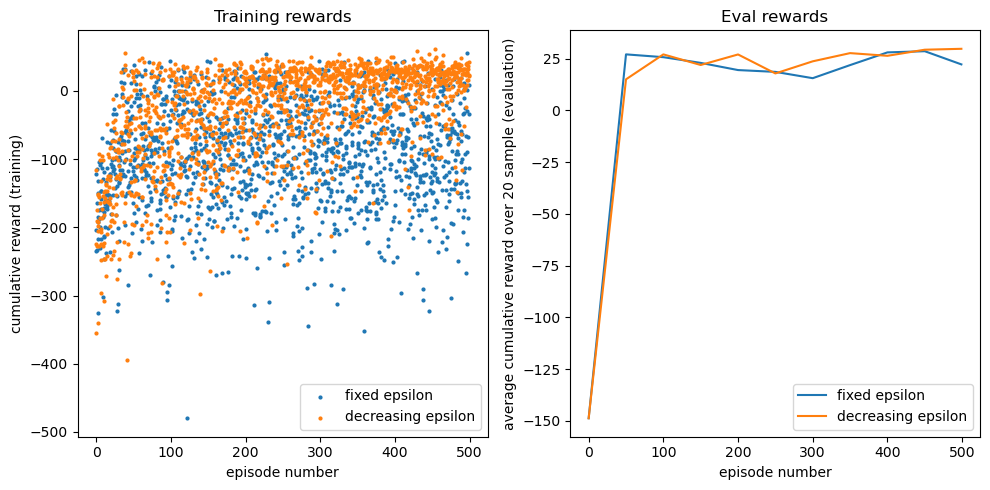

In [88]:
with open(RESULTS_FOLDER + 'deep_q_learning.pkl', 'rb') as file:
    training_curves_ad_russo =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_dec_epsilon.pkl', 'rb') as file:
    training_curves_dec_eps =  pickle.load(file)
plot_training_curves([training_curves_ad_russo,training_curves_dec_eps])

print(f"max reward fixed epsilon : {np.max([t['rlog_eval'] for t in training_curves_ad_russo])}")
print(f"max reward fixed epsilon : {np.max([t['rlog_eval'] for t in training_curves_dec_eps])}")

### Question 3.c) Evaluation


In [135]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = LR,
                    epsilon = EPSILON,
                    gamma = GAMMA,
                    buffer_size=BF_SIZE,
                    batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_dec_epsilon.pkl')


""" Run the evaluation """
logs, rewards = evaluate(env,agent)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])
isol_days = np.array([np.sum(np.array(l['actions']['isolation']).astype(np.uint8))*7 for l in logs])
vaccination_days = np.array([np.sum(np.array(l['actions']['vaccinate']).astype(np.uint8))*7 for l in logs])
hosp_days = np.array([np.sum(np.array(l['actions']['hospital']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

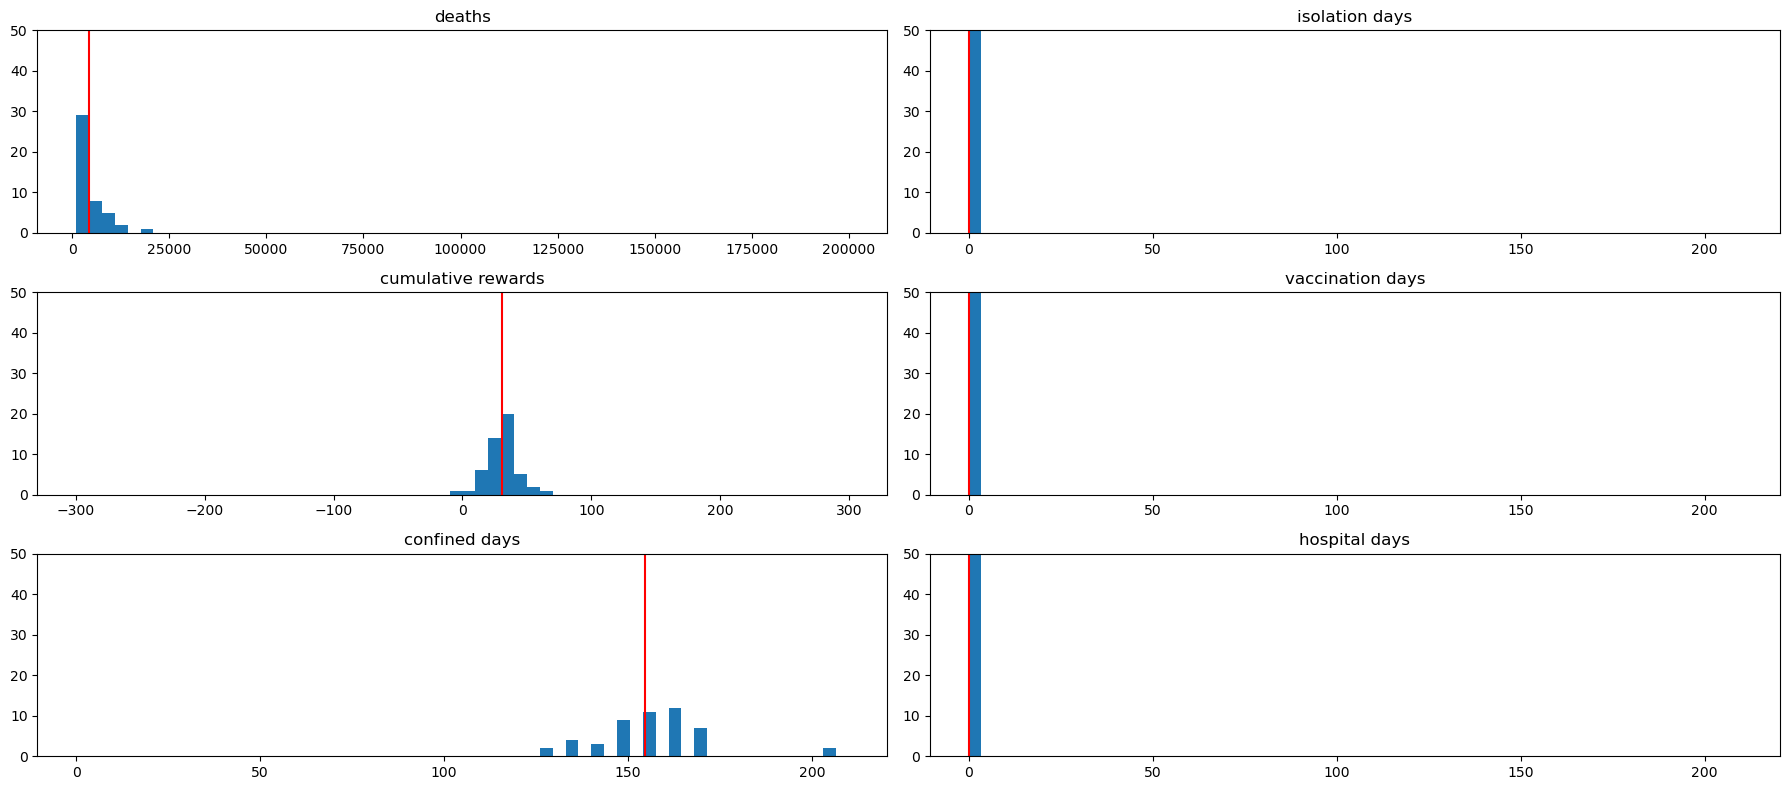

Average death number: 4344.14
Average cumulative reward: 31.01858036994934
Average number of confinement days: 154.7
Average number of isolation days: 0.0
Average number of vaccination days: 0.0
Average number of additional hospital days: 0.0


In [136]:
""" Plotting the results """
fig, ax = plt.subplots(3,2,figsize=(18,8))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0,0], deaths,'deaths',(1000,200000),50)
hist_avg(ax[1,0], rewards,'cumulative rewards',(-300,300),50)
hist_avg(ax[2,0], conf_days,'confined days',(0,210),50)
hist_avg(ax[0,1], isol_days,'isolation days',(0,210),50)
hist_avg(ax[1,1], vaccination_days,'vaccination days',(0,210),50)
hist_avg(ax[2,1], hosp_days,'hospital days',(0,210),50)
fig.tight_layout()
plt.show()

""" Saving the results """
EVALUATION_DICT['DQN'] = {
    'deaths' : np.mean(deaths),
    'confinement' : np.mean(conf_days),
    'isolation' : 0.,
    'vaccination' : 0.,
    'hospital' : 0.,
    'rewards' : np.mean(rewards),
}

""" Printing the results """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confinement days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(isol_days)}')
print(f'Average number of vaccination days: {np.mean(vaccination_days)}')
print(f'Average number of additional hospital days: {np.mean(hosp_days)}')

## 4. Dealing with a more complex action space

### Question 4.1.b) Toggle-action-space multi-action policy training

#### Action / Observation Preprocessors

In [40]:
SCALE = 100 
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

def toggle_act_pre(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action()
    
    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
    elif a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
    
    return action
    
def toggle_obs_pre(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * \
        np.array([np.array(obs.city[c].infected)/
                    obs.pop[c] for c in dyn.cities])
    dead = SCALE * \
        np.array([np.array(obs.city[c].infected)/obs.pop[c]
                    for c in dyn.cities])
    confined = np.ones_like(
        dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

#### Training the agent

In [41]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(5),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(3, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=toggle_act_pre,
            observation_preprocessor=toggle_obs_pre,
            )


RUN_NAME = 'deep_q_learning_toggle'
MODEL_FOLDER = 'models/'
RESULTS_FOLDER = 'results/'
NUM_EPISODES = 500
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 10
NUM_TRACES = 3
LR=1e-5
GAMMA = 0.9
BF_SIZE = 20000
BATCH_SIZE = 2048
EPSILON_0 = 0.7
EPSILON_MIN = 0.2
T_MAX = 500
NUM_TRACES = 3

In [42]:
max_reward = -1e10
traces = []
for seed in range(NUM_TRACES):
    """Ensure deterministic training"""
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    
    """Initialize new agent (one per trace, different seed)"""
    agent = DQNAgent(    env = env,
                            model = DQN,
                            criterion = nn.HuberLoss(),
                            lr = LR,
                            epsilon = EPSILON_0,
                            gamma = GAMMA,
                            buffer_size=BF_SIZE,
                            batch_size=BATCH_SIZE)
        
    rlog_training = []
    rlog_eval = []
    x_eval = []
    for episode in tqdm(range(NUM_EPISODES)):
        if episode % TARGET_UPDATE_RATE == 0:
            agent.targetModel.load_state_dict(agent.model.state_dict())

        finished = False
        obs, info = env.reset((1+seed)*episode) #ensure that each run is uniquely seeded
        agent.reset()
        agent.epsilon = max([EPSILON_0*(T_MAX-episode)/T_MAX,
                            EPSILON_MIN])
        
        R_cum = 0
        while not finished:
            action, est_Q = agent.act(obs)
            obs_next, R, finished, info = env.step(action)
            agent.memory.push(obs, action, obs_next, R)
            loss = agent.optimize_model()
            obs = obs_next; R_cum += R
            if finished:
                break
        rlog_training.append(R_cum)
        if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
            agent.epsilon = 0 # evaluation runs are performed with epsilon = 0
            _, rewards = evaluate(env, agent, eval_iterations = EVAL_SAMPLES,pbar=False)
            R_eval = np.mean(rewards)
            rlog_eval.append(R_eval); x_eval.append(episode)
            print( f"Evaluated cumulative reward R={R_eval}.")
            
            if R_eval > max_reward:
                max_reward = R_eval; print( f"    New maximum reward, saving weights!")
                torch.save(agent.model, MODEL_FOLDER + RUN_NAME + '.pkl')
                
    traces += [{
        'run_name': 'toggled action space',
        'x_eval': x_eval,
        'rlog_training': rlog_training,
        'rlog_eval': rlog_eval,
    }]
    
RESULTS_FOLDER = 'results/'
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(traces,file)

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-169.4980983734131.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-169.4980983734131.
Evaluated cumulative reward R=-134.00618019104004.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-73.32598609924317.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-57.804633712768556.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-109.43562364578247.
Evaluated cumulative reward R=-52.30529180765152.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-34.577122557163236.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-30.974634420871734.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-30.683891773223877.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-27.732451021671295.
    New maximum reward, saving weights!


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-196.37733268737793.
Evaluated cumulative reward R=-196.37733268737793.
Evaluated cumulative reward R=-166.37177543640138.
Evaluated cumulative reward R=-96.94660062789917.
Evaluated cumulative reward R=-86.27441568374634.
Evaluated cumulative reward R=-61.276936531066895.
Evaluated cumulative reward R=-81.88974252045155.
Evaluated cumulative reward R=-54.67435833066702.
Evaluated cumulative reward R=-51.70448254644871.
Evaluated cumulative reward R=-52.96686638593674.
Evaluated cumulative reward R=-30.48623857498169.


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-96.57431468963622.
Evaluated cumulative reward R=-96.57431468963622.
Evaluated cumulative reward R=-113.5296950340271.
Evaluated cumulative reward R=-20.963708305358885.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-8.624229049682617.
    New maximum reward, saving weights!
Evaluated cumulative reward R=-48.91566953659058.
Evaluated cumulative reward R=-48.39311828613281.
Evaluated cumulative reward R=-42.544697761535645.
Evaluated cumulative reward R=-42.37064609527588.
Evaluated cumulative reward R=-37.63913369178772.
Evaluated cumulative reward R=-30.152459144592285.


#### Plotting the training curves

/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.concatenate([np.array(n['rlog_training']) for n in nr]),4)
/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.concatenate([np.array(n['rlog_training']) for n

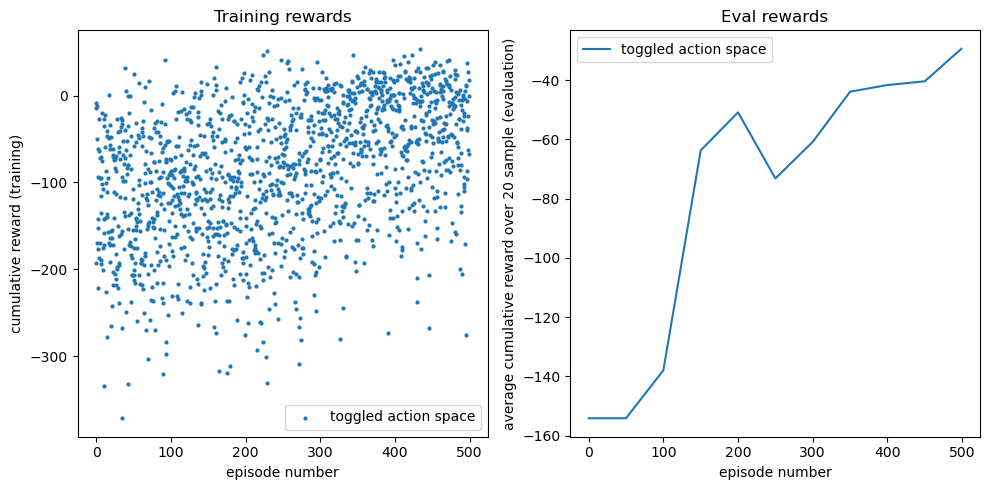

In [96]:
with open(RESULTS_FOLDER + 'deep_q_learning_toggle.pkl', 'rb') as file:
    training_curves_toggle =  pickle.load(file)
    
plot_training_curves([training_curves_toggle])

#### Running and plotting an example episode

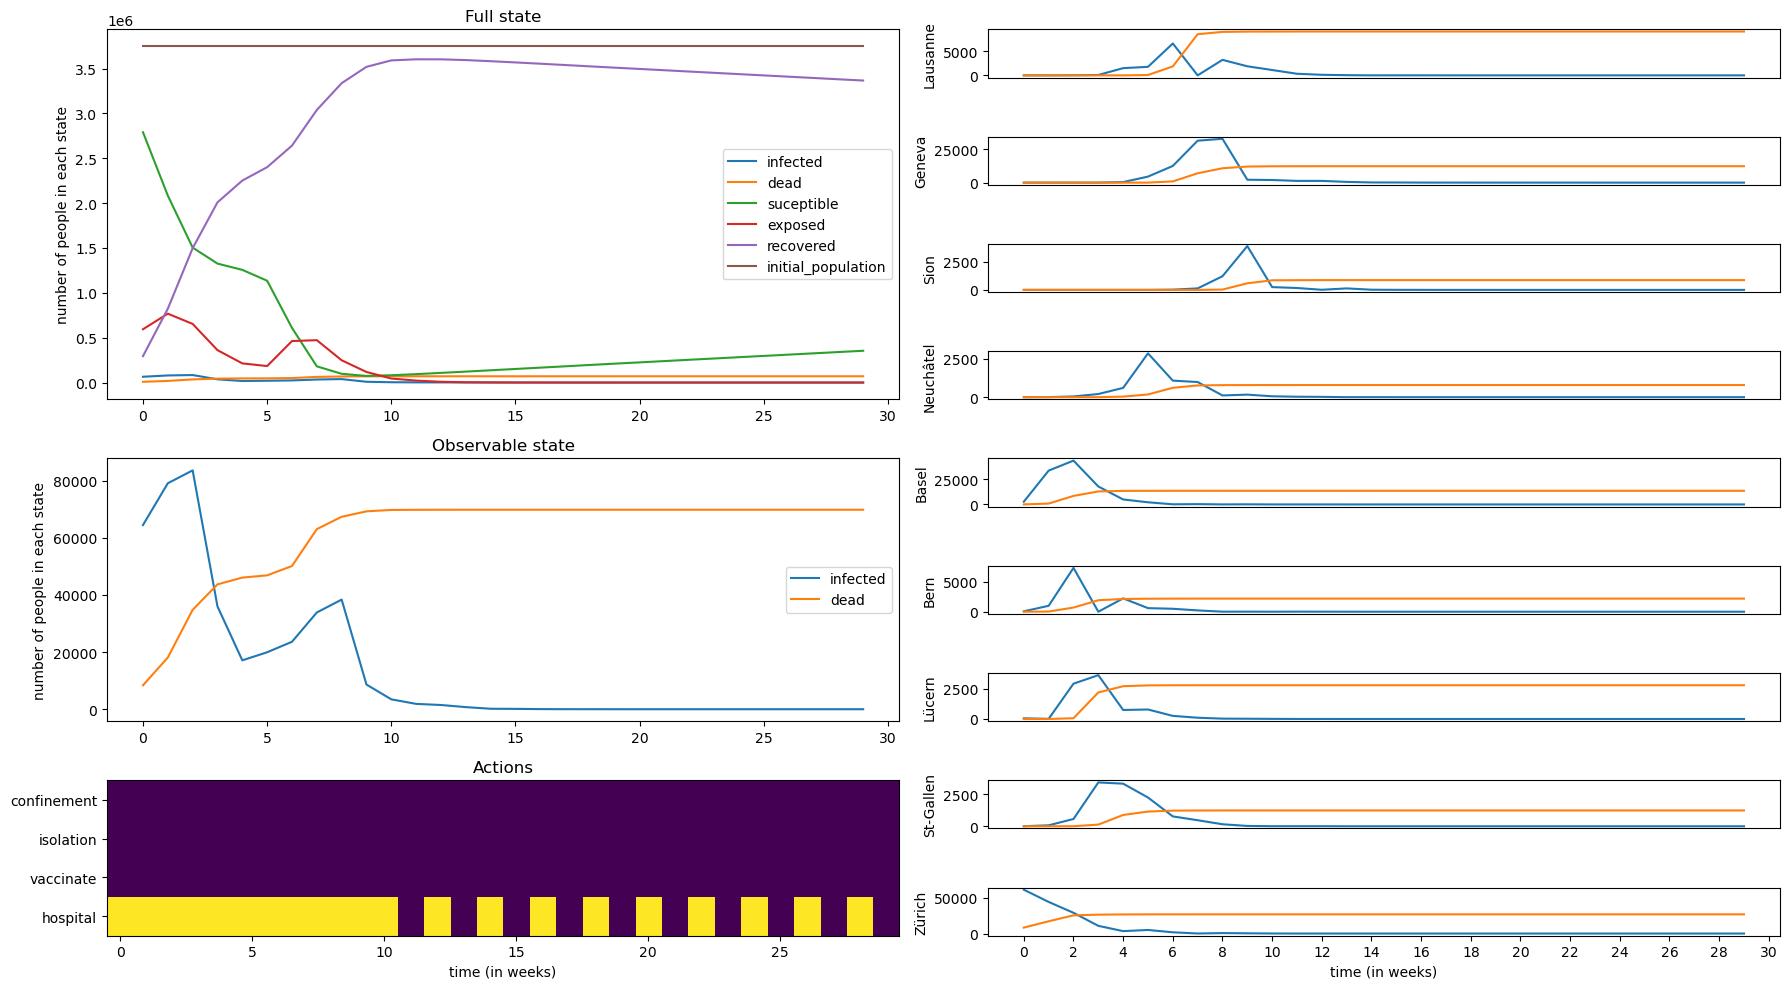

In [98]:

dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(5),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(3, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=toggle_act_pre,
            observation_preprocessor=toggle_obs_pre,
            )
agent = DQNAgent(    env = env,
                            model = DQN,
                            criterion = nn.HuberLoss(),
                            lr = LR,
                            epsilon = EPSILON,
                            gamma = GAMMA,
                            buffer_size=BF_SIZE,
                            batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_toggle.pkl')

""" Run the simulation """
log = []
qvals = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action, q = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info); qvals.append(q) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

plot_episode(total,cities,actions)

### Question 4.1.c) Evaluation of the toggled multi-action agent

In [161]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(5),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(3, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=toggle_act_pre,
            observation_preprocessor=toggle_obs_pre,
            )
agent = DQNAgent(    env = env,
                            model = DQN,
                            criterion = nn.HuberLoss(),
                            lr = LR,
                            epsilon = EPSILON,
                            gamma = GAMMA,
                            buffer_size=BF_SIZE,
                            batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_toggle.pkl')


""" Run the evaluation """
logs, rewards = evaluate(env,agent)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])
isol_days = np.array([np.sum(np.array(l['actions']['isolation']).astype(np.uint8))*7 for l in logs])
vaccination_days = np.array([np.sum(np.array(l['actions']['vaccinate']).astype(np.uint8))*7 for l in logs])
hosp_days = np.array([np.sum(np.array(l['actions']['hospital']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

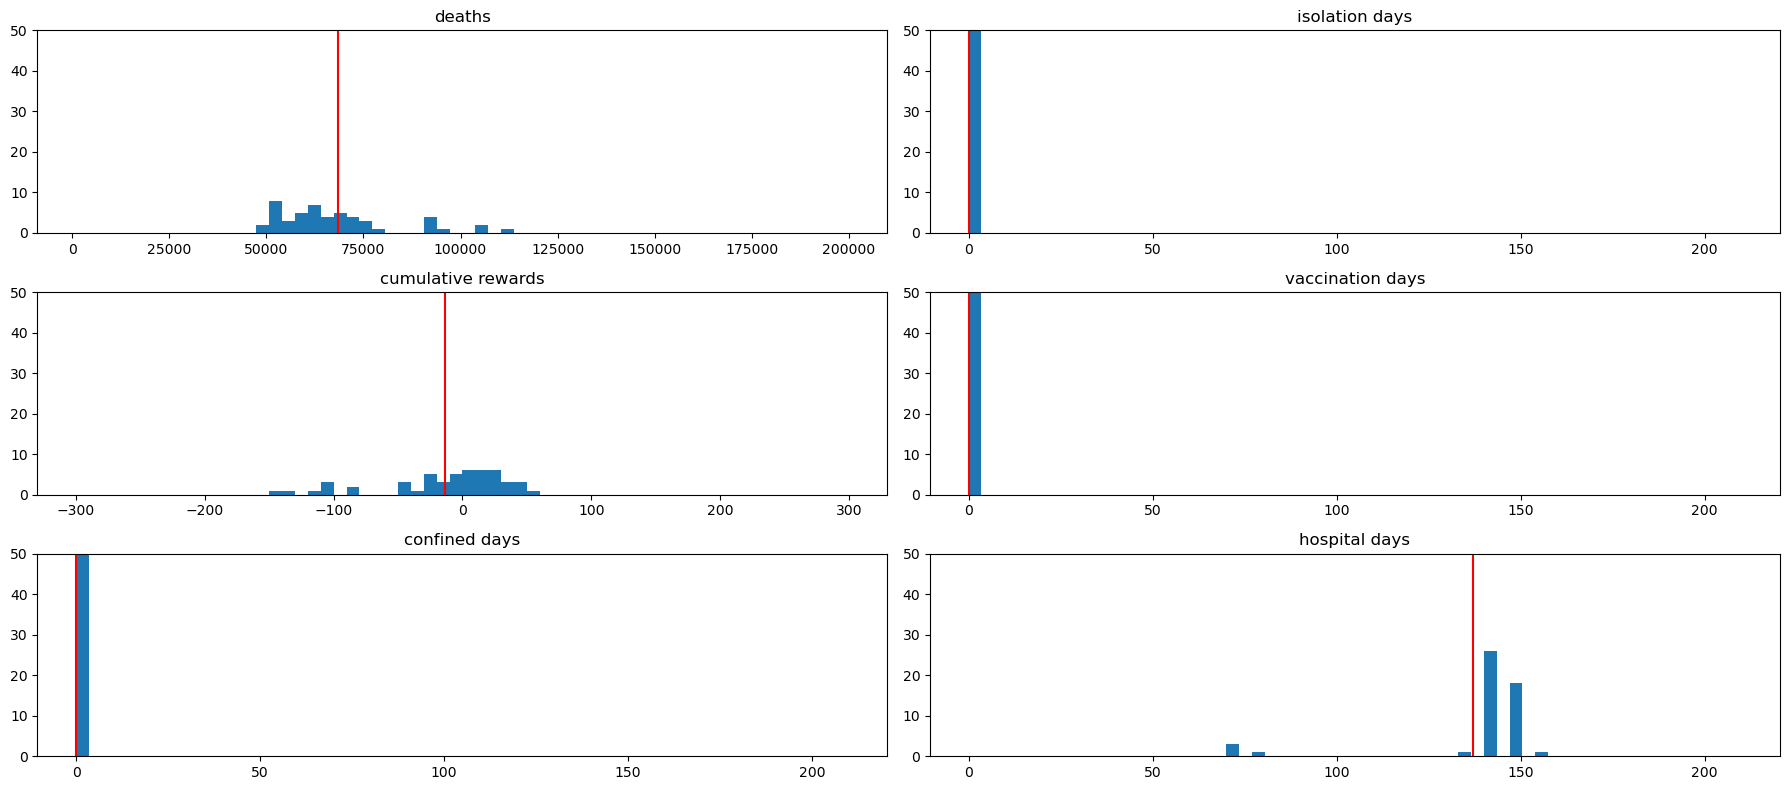

Average death number: 68323.76
Average cumulative reward: -13.598557281494141
Average number of confinement days: 0.0
Average number of isolation days: 0.0
Average number of vaccination days: 0.0
Average number of additional hospital days: 137.2


In [162]:
""" Plotting the results """
fig, ax = plt.subplots(3,2,figsize=(18,8))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0,0], deaths,'deaths',(1000,200000),50)
hist_avg(ax[1,0], rewards,'cumulative rewards',(-300,300),50)
hist_avg(ax[2,0], conf_days,'confined days',(0,210),50)
hist_avg(ax[0,1], isol_days,'isolation days',(0,210),50)
hist_avg(ax[1,1], vaccination_days,'vaccination days',(0,210),50)
hist_avg(ax[2,1], hosp_days,'hospital days',(0,210),50)
fig.tight_layout()
plt.show()

""" Saving the results """
EVALUATION_DICT['Toggle'] = {
    'deaths' : np.mean(deaths),
    'confinement' : np.mean(conf_days),
    'isolation' : np.mean(isol_days),
    'vaccination' : np.mean(vaccination_days),
    'hospital' : np.mean(hosp_days),
    'rewards' : np.mean(rewards),
}

""" Printing the results """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confinement days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(isol_days)}')
print(f'Average number of vaccination days: {np.mean(vaccination_days)}')
print(f'Average number of additional hospital days: {np.mean(hosp_days)}')

### Question 4.2.a) multi-action factorized Q-values policy training

#### Implementation of the Agent Class

In [124]:
class FactoredDQN(nn.Module):
    """Fully connected Factored Q-Value estimator network."""

    def __init__(self, in_dim:int=126, out_dim:int=16 )-> nn.Module:
        """        
        Args:
            in_dim (int, optional): input dimensionality. Defaults to 126.
            out_dim (int, optional): output dimensionality. Defaults to 16.
            dropout (float, optional): dropout rate. Defaults to 0.
            small (bool, optional): if true, the network has 2 layers, else it has 4. Defaults to False.

        Returns:
            nn.Module: The Deep-Q-Network.
        """
        super().__init__()
        # DQN module
        self.out_dim = out_dim
        self.dqn = DQN(in_dim,out_dim)

    def forward(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        """Forward pass through the deep-q-network module

        Args:
            x (Tensor): input

        Returns:
            Tuple[Tensor,Tensor]: (actions, q_values)
        """
        y = torch.reshape(self.dqn(x), (x.shape[0],2,self.out_dim//2))
        qmax = torch.max(y,axis=1)
        return qmax.indices, y, torch.sum(qmax.values)


class FactoredDQNAgent(Agent):
    """Implements acting and learning using factored deep Q learning.  
    """

    def __init__(self,  env:Env,
                 model:torch.nn.Module,
                 criterion=nn.HuberLoss(),
                 lr:float=1e-3,
                 epsilon:float=0.5,
                 gamma:float=0.99,
                 buffer_size:int=10000,
                 batch_size:int=64):
        """

        Args:
            env (_type_): the simulation environment.
            model (_type_): the torch module to use for learning
            criterion (nn._Loss, optional): the loss function. Defaults to nn.HuberLoss().
            lr (float, optional): DQN's learning rate. Defaults to 1e-3.
            epsilon (float, optional): the exploration ratio epsilon (see above). Defaults to 0.5.
            gamma (float, optional): the gamma term (see above). Defaults to 0.99.
            buffer_size (int, optional): the replay buffer size. Defaults to 10000.
            batch_size (int, optional): the size of each training batch. Defaults to 64.
        """

        self.env = env

        model_params = {
            'in_dim': len(env.observation_space.sample().flatten()),
            'out_dim': 2*env.dyn.ACTION_CARDINALITY, # we want twice as many neurons as there are binary actions
        }
        self.model = model(**model_params)
        self.targetModel = model(**model_params)

        self.criterion = criterion

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.memory = ReplayMemory(buffer_size)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.lr = lr

    def load_model(self, savepath):
        torch.save(self.model.state_dict(), savepath)
        self.model.load_state_dict(torch.load(savepath))

    def save_model(self, savepath):
        torch.save(self.model.state_dict(), savepath)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return np.double(0)

        # Sample memory
        transitions = self.memory.sample(self.batch_size)

        # Convert Batch(Transitions) -> Transition(Batch)
        batch = Transition(*zip(*transitions))

        action_batch = torch.cat([torch.LongTensor(e) for e in batch.action],axis=0)
        state_batch = torch.cat(batch.state, 0)
        next_states_batch = torch.cat(batch.next_state, 0)
        reward_batch = torch.cat(batch.reward)
        # Compute Q(S, a) with the Q-value network
        _,q_est,_ = self.model(state_batch)
        state_action_values = torch.sum(q_est.gather(1,action_batch.unsqueeze(1)),axis=2)

        # Compute max_ap Q(Sp) with the stable target network
        _,q_target,_ = self.targetModel(next_states_batch)
        next_state_values = torch.sum(q_target.max(1).values.unsqueeze(1),axis=2)
        # Compute the expected Q values
        expected_state_action_values = (
                    next_state_values * self.gamma) + reward_batch

        # Compute the loss
        loss = self.criterion(state_action_values,
                              expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return np.double(loss)
    
    def reset(self,):
        pass # Not stateful

    def act(self, obs):
        
        x = torch.Tensor(obs)

        act,Q_tensor,Q_sum = self.model(x)
        Q = float(Q_sum.detach())
        if random.random() > self.epsilon:
            return act, Q_tensor
        else:
            return np.array([self.env.action_space.sample()]), Q_tensor

#### Action Preprocessor

In [125]:
def factor_act_pre(a:torch.Tensor, dyn:ModelDynamics):
    return {
        'confinement':  bool(a[0,0]==0),
        'isolation':    bool(a[0,1]==0),
        'hospital':     bool(a[0,2]==0),
        'vaccinate':    bool(a[0,3]==0),
    }

#### Training the agent

In [50]:
env = Env(  dyn,
            action_space=spaces.MultiBinary(4),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=factor_act_pre,
            observation_preprocessor=naive_obs_pre,
        )

RUN_NAME = 'deep_q_learning_factor'
MODEL_FOLDER = 'models/'
RESULTS_FOLDER = 'results/'
NUM_EPISODES = 500
EVAL_RATE = 50
EVAL_SAMPLES = 20
TARGET_UPDATE_RATE = 10
NUM_TRACES = 3
LR=1e-5
GAMMA = 0.9
BF_SIZE = 20000
BATCH_SIZE = 2048
EPSILON_0 = 0.7
EPSILON_MIN = 0.2
T_MAX = 500
NUM_TRACES = 3

In [51]:
max_reward = -1e10
traces = []
for seed in range(NUM_TRACES):
    
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    
    """Initialize a new agent (one per trace)"""
    agent = FactoredDQNAgent(    env = env,
                                model = FactoredDQN,
                                criterion = nn.HuberLoss(),
                                lr = LR,
                                epsilon = EPSILON_0,
                                gamma = GAMMA,
                                buffer_size = BF_SIZE,
                                batch_size = BATCH_SIZE)

    rlog_training = []
    rlog_eval = []
    x_eval = []
    for episode in tqdm(range(NUM_EPISODES)):
        if episode % TARGET_UPDATE_RATE == 0:
            agent.targetModel.load_state_dict(agent.model.state_dict())

        finished = False
        obs, info = env.reset((1+seed)*episode)
        agent.reset()
        agent.epsilon = max([EPSILON_0*(T_MAX-episode)/T_MAX,
                            EPSILON_MIN])
        
        R_cum = 0
        while not finished:
            action, est_Q = agent.act(obs)
            obs_next, R, finished, info = env.step(action)
            agent.memory.push(obs, action, obs_next, R)
            loss = agent.optimize_model()
            obs = obs_next; R_cum += R
            if finished:
                break
        rlog_training.append(R_cum)
        if episode % EVAL_RATE == 0 or (episode == NUM_EPISODES-1):
            agent.epsilon = 0 # evaluation runs are performed with epsilon = 0
            _, rewards = evaluate(env, agent, eval_iterations = EVAL_SAMPLES,pbar=False)
            R_eval = np.mean(rewards)
            rlog_eval.append(R_eval); x_eval.append(episode)
            print( f"Evaluated cumulative reward R={R_eval}.")
            
            if R_eval > max_reward:
                max_reward = R_eval; print( f"    New maximum reward, saving weights!")
                torch.save(agent.model, MODEL_FOLDER + RUN_NAME + '.pkl')
                
    RESULTS_FOLDER = 'results/'
    traces += [{
        'run_name': 'factored action space',
        'x_eval': x_eval,
        'rlog_eval': rlog_eval,
        'rlog_training': rlog_training,
    }]
    
with open(RESULTS_FOLDER + RUN_NAME + '.pkl', 'wb') as file:
    pickle.dump(traces,file)

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=40.633710098266604.
    New maximum reward, saving weights!
Evaluated cumulative reward R=40.633710098266604.
Evaluated cumulative reward R=-11.038369941711426.
Evaluated cumulative reward R=-53.47056007385254.
Evaluated cumulative reward R=44.05885601043701.
    New maximum reward, saving weights!
Evaluated cumulative reward R=29.67644739151001.
Evaluated cumulative reward R=-5.7124279022216795.
Evaluated cumulative reward R=-9.094520139694215.
Evaluated cumulative reward R=-35.70055503845215.
Evaluated cumulative reward R=-17.454471111297607.
Evaluated cumulative reward R=-5.187899965047836.


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=-147.1871025085449.
Evaluated cumulative reward R=-147.1871025085449.
Evaluated cumulative reward R=-106.68759803771972.
Evaluated cumulative reward R=-70.49881782531739.
Evaluated cumulative reward R=-83.36477031707764.
Evaluated cumulative reward R=-57.695370483398435.
Evaluated cumulative reward R=-18.47311716079712.
Evaluated cumulative reward R=21.345233583450316.
Evaluated cumulative reward R=-5.2287732571363446.
Evaluated cumulative reward R=-18.33402626514435.
Evaluated cumulative reward R=-9.502655398845672.


  0%|          | 0/500 [00:00<?, ?it/s]

Evaluated cumulative reward R=16.992062997817992.
Evaluated cumulative reward R=16.992062997817992.
Evaluated cumulative reward R=17.29606294631958.
Evaluated cumulative reward R=-57.618212652206424.
Evaluated cumulative reward R=-67.3791467666626.
Evaluated cumulative reward R=-13.12371039390564.
Evaluated cumulative reward R=2.6899384021759034.
Evaluated cumulative reward R=1.6725233316421508.
Evaluated cumulative reward R=-18.908478474617006.
Evaluated cumulative reward R=-10.90053207874298.
Evaluated cumulative reward R=-8.744204664230347.


#### Plotting the training curves

/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.concatenate([np.array(n['rlog_training']) for n in nr]),4)
/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.concatenate([np.array(n['rlog_training']) for n

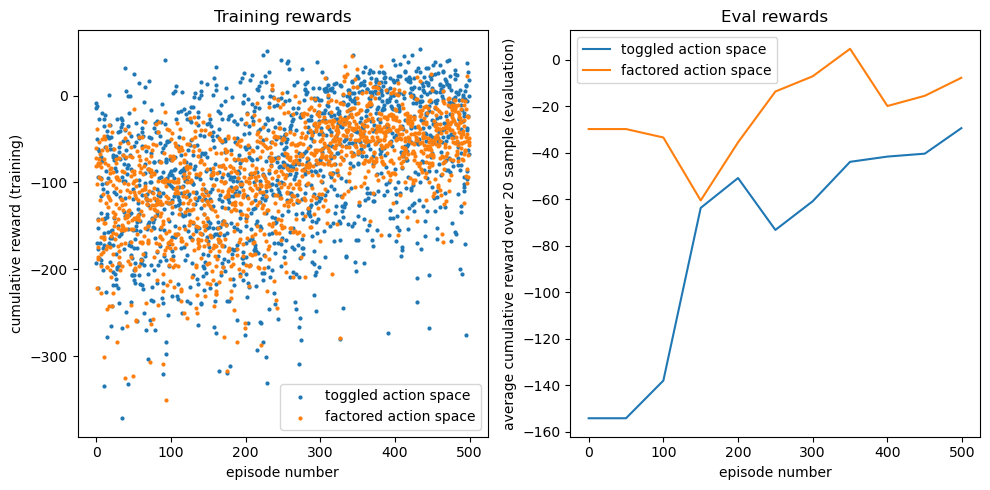

In [126]:
with open(RESULTS_FOLDER + 'deep_q_learning_toggle.pkl', 'rb') as file:
    training_curves_toggle =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_factor.pkl', 'rb') as file:
    training_curves_factor =  pickle.load(file)
    
plot_training_curves([ training_curves_toggle,training_curves_factor])

#### Plotting an example episode

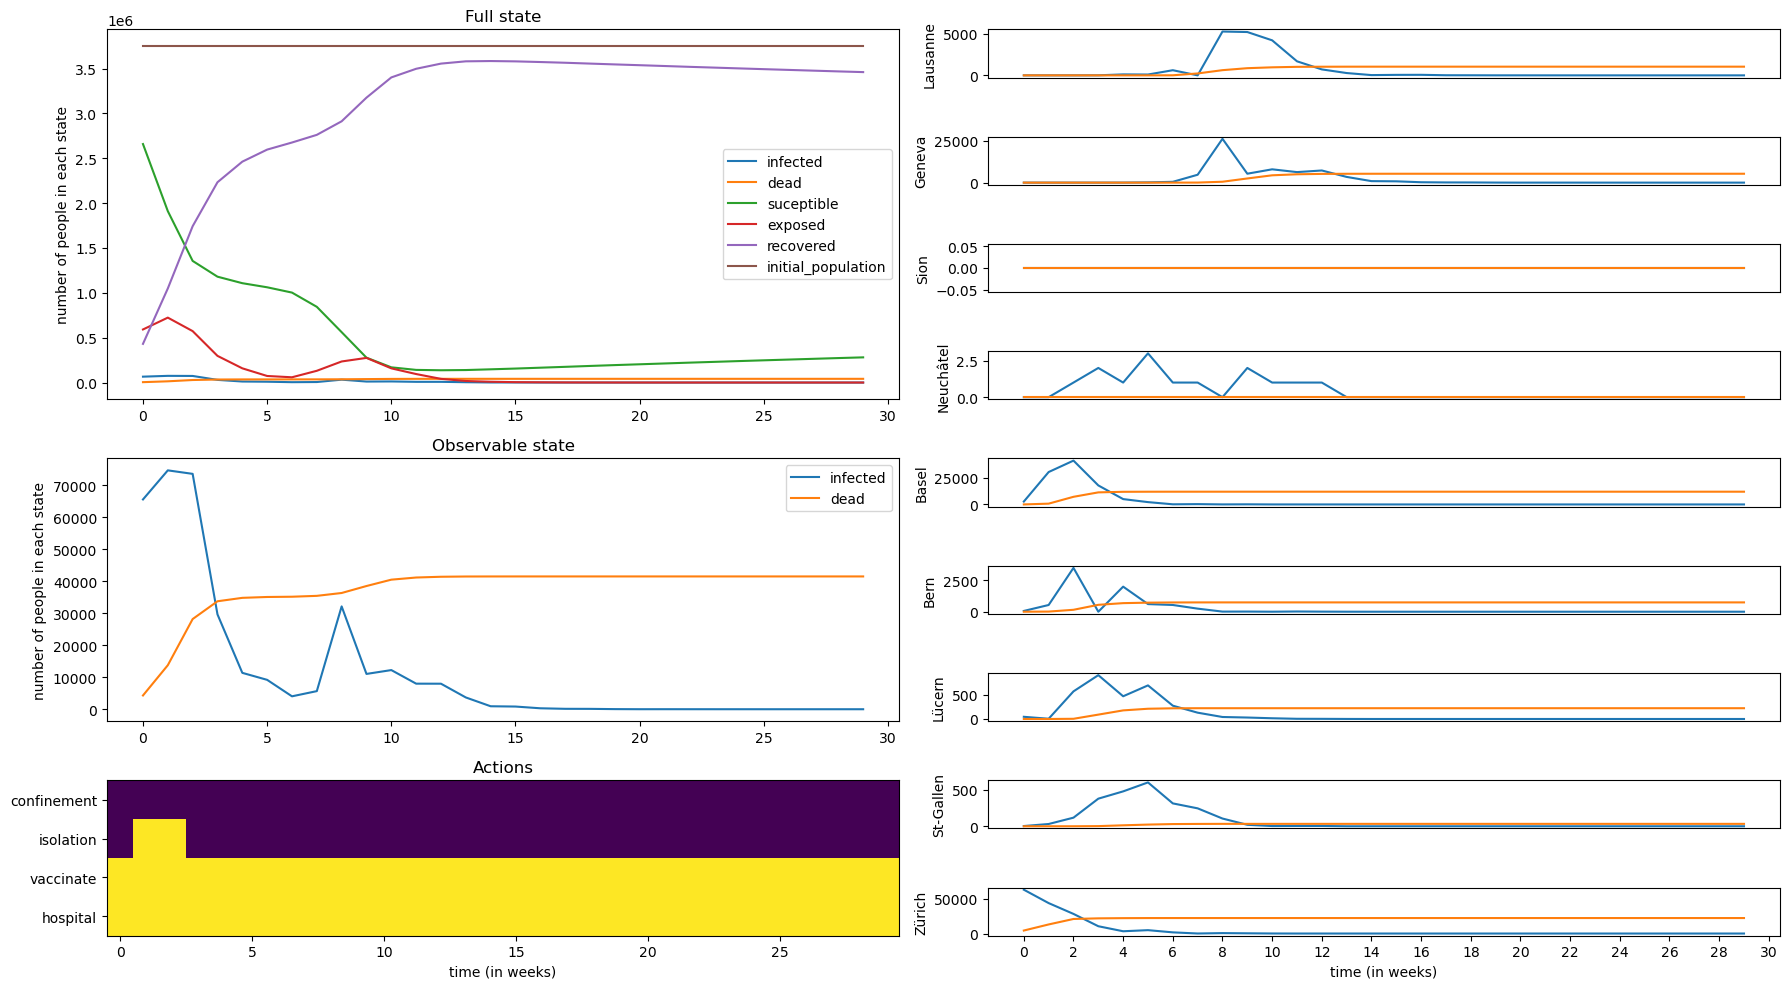

In [127]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.MultiBinary(4),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=factor_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = FactoredDQNAgent(    env = env,
                            model = FactoredDQN,
                            criterion = nn.HuberLoss(),
                            lr = LR,
                            epsilon = EPSILON,
                            gamma = GAMMA,
                            buffer_size=BF_SIZE,
                            batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_factor.pkl')

""" Run the simulation """
log = []
qvals = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action, q = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info), qvals.append(q) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

plot_episode(total,cities,actions)

### Question 4.2.b) multi-action factorized Q-values policy evaluation

In [159]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.MultiBinary(4),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=factor_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = FactoredDQNAgent(    env = env,
                            model = FactoredDQN,
                            criterion = nn.HuberLoss(),
                            lr = LR,
                            epsilon = EPSILON,
                            gamma = GAMMA,
                            buffer_size=BF_SIZE,
                            batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_factor.pkl')


""" Run the evaluation """
logs, rewards = evaluate(env,agent)

""" Parse the data """
deaths = np.array([l['total']['dead'][-1] for l in logs])
conf_days = np.array([np.sum(np.array(l['actions']['confinement']).astype(np.uint8))*7 for l in logs])
isol_days = np.array([np.sum(np.array(l['actions']['isolation']).astype(np.uint8))*7 for l in logs])
vaccination_days = np.array([np.sum(np.array(l['actions']['vaccinate']).astype(np.uint8))*7 for l in logs])
hosp_days = np.array([np.sum(np.array(l['actions']['hospital']).astype(np.uint8))*7 for l in logs])

Eval iteration:   0%|          | 0/50 [00:00<?, ?it/s]

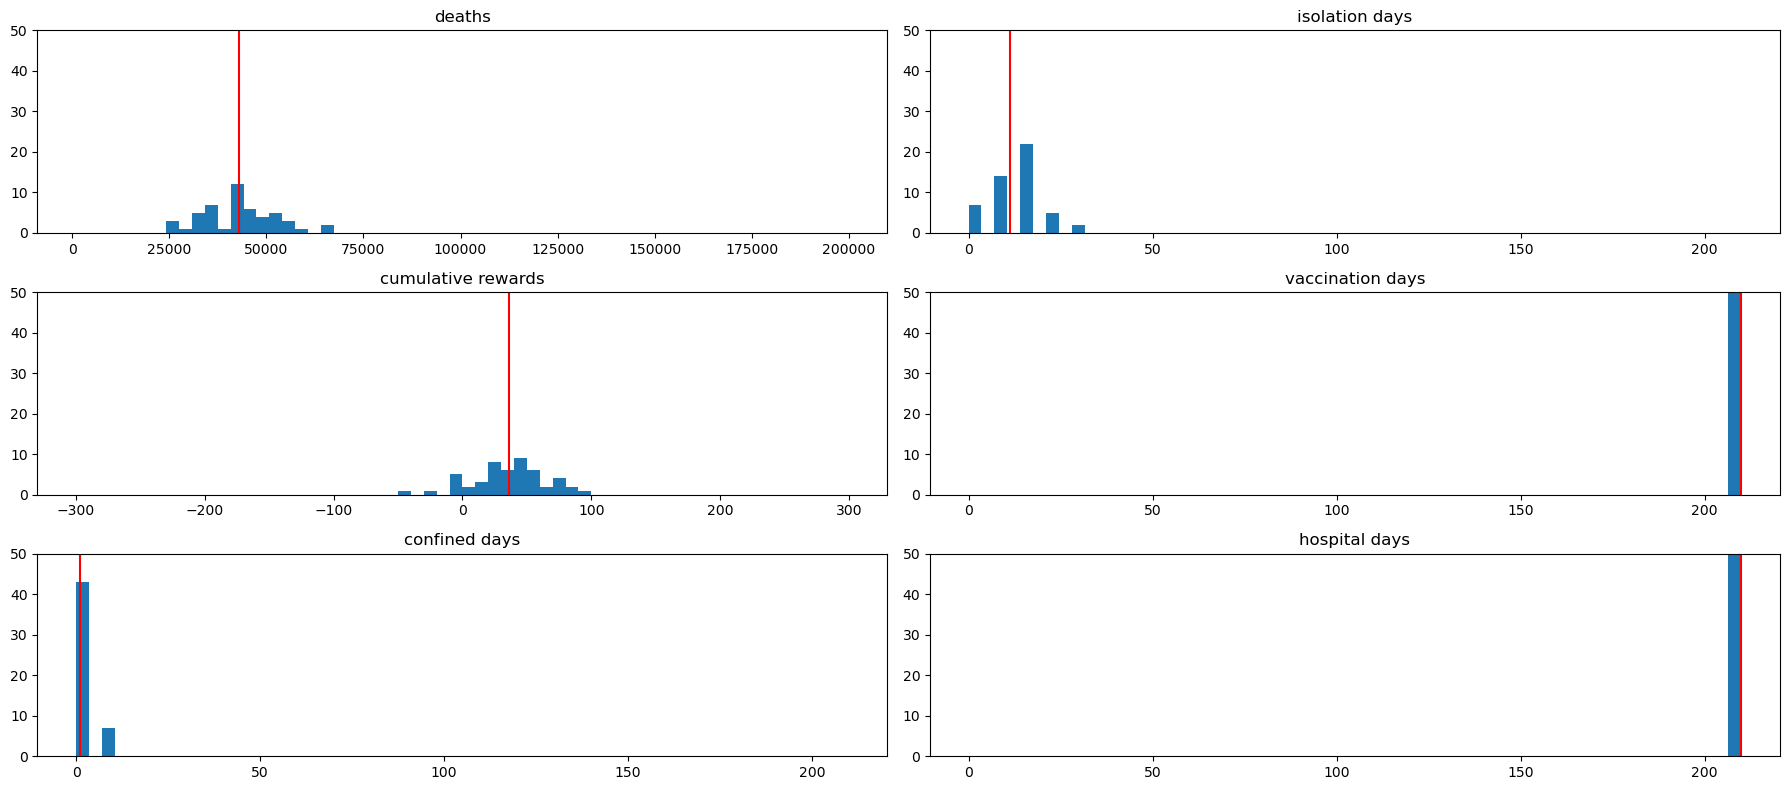

Average death number: 43068.14
Average cumulative reward: 36.29114345550537
Average number of confinement days: 0.98
Average number of isolation days: 11.34
Average number of vaccination days: 210.0
Average number of additional hospital days: 210.0


In [160]:
""" Plotting the results """
fig, ax = plt.subplots(3,2,figsize=(18,8))
def hist_avg(ax, data,title,x_range,ymax):
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0,0], deaths,'deaths',(1000,200000),50)
hist_avg(ax[1,0], rewards,'cumulative rewards',(-300,300),50)
hist_avg(ax[2,0], conf_days,'confined days',(0,210),50)
hist_avg(ax[0,1], isol_days,'isolation days',(0,210),50)
hist_avg(ax[1,1], vaccination_days,'vaccination days',(0,210),50)
hist_avg(ax[2,1], hosp_days,'hospital days',(0,210),50)
fig.tight_layout()
plt.show()

""" Saving the results """
EVALUATION_DICT['Factor'] = {
    'deaths' : np.mean(deaths),
    'confinement' : np.mean(conf_days),
    'isolation' : np.mean(isol_days),
    'vaccination' : np.mean(vaccination_days),
    'hospital' : np.mean(hosp_days),
    'rewards' : np.mean(rewards),
}

""" Printing the results """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Average number of confinement days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(isol_days)}')
print(f'Average number of vaccination days: {np.mean(vaccination_days)}')
print(f'Average number of additional hospital days: {np.mean(hosp_days)}')

## 5. Wrapping Up

### Question 5.a) Result Analysis : training curves

We plot all training curves here.

/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.concatenate([np.array(n['rlog_training']) for n in nr]),4)
/var/folders/qg/xwsfw_lx3td6x7pm_kt1q3yc0000gn/T/ipykernel_75202/2013854860.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.concatenate([np.array(n['rlog_training']) for n

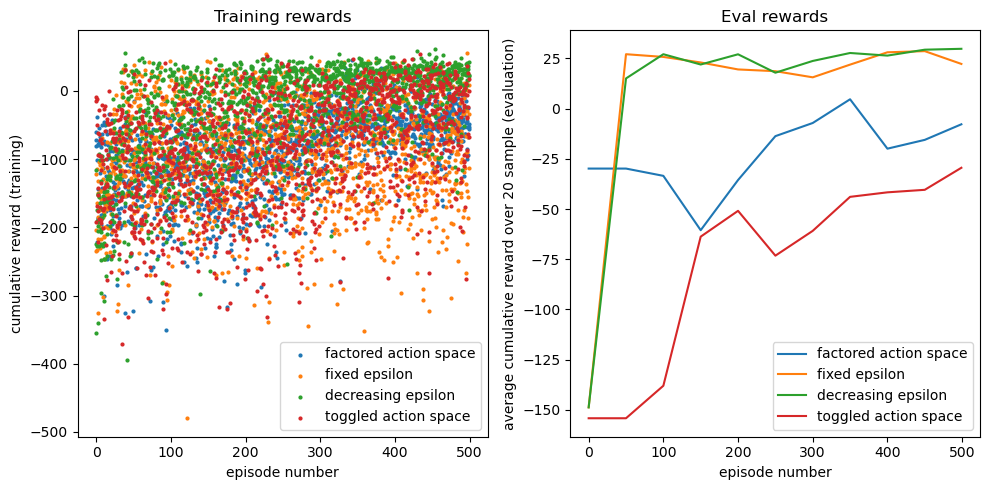

In [140]:

with open(RESULTS_FOLDER + 'deep_q_learning.pkl', 'rb') as file:
    training_curves_ad_russo =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_dec_epsilon.pkl', 'rb') as file:
    training_curves_dec_eps =  pickle.load(file)

with open(RESULTS_FOLDER + 'deep_q_learning_toggle.pkl', 'rb') as file:
    training_curves_toggle =  pickle.load(file)
with open(RESULTS_FOLDER + 'deep_q_learning_factor.pkl', 'rb') as file:
    training_curves_factor =  pickle.load(file)
    
plot_training_curves([training_curves_factor,
                      training_curves_ad_russo,
                      training_curves_dec_eps,
                      training_curves_toggle])

### Question 5.b) Result Analysis : comparing policies

We just autogenerate tabular code to paste into the report.

In [182]:
header = ['Policy']+list(EVALUATION_DICT['Russo'].keys())
lines = [header]
for k in EVALUATION_DICT.keys():
    l = [k]+[ round(e,2) for e in EVALUATION_DICT[k].values()]
    lines += [l]

" \\ ".join([" & ".join([str(e) for e in l]) for l in lines])

'Policy & deaths & confinement & isolation & vaccination & hospital & rewards \\ Russo & 57749.34 & 110.46 & 0.0 & 0.0 & 0.0 & -73.27 \\ DQN & 4344.14 & 154.7 & 0.0 & 0.0 & 0.0 & 31.02 \\ Factor & 43068.14 & 0.98 & 11.34 & 210.0 & 210.0 & 36.29 \\ Toggle & 68323.76 & 0.0 & 0.0 & 0.0 & 137.2 & -13.6'

### Question 5.c) Interpretability : Q-values

### Running a DQN-episode

In [184]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.Discrete(2),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=binary_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = DQNAgent(   env = env,
                    model = DQN,
                    criterion = nn.HuberLoss(),
                    lr = LR,
                    epsilon = EPSILON,
                    gamma = GAMMA,
                    buffer_size=BF_SIZE,
                    batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_dec_epsilon.pkl')

""" Run the simulation """
log = []
qvals_DQN = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action, q = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info);qvals_DQN.append(q) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total_DQN = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities_DQN = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions_DQN = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

### Running a multi-action-factored-episode

In [185]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment and the agent"""
env = Env(  dyn,
            action_space=spaces.MultiBinary(4),
            observation_space=spaces.Box(   low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16),
            action_preprocessor=factor_act_pre,
            observation_preprocessor=naive_obs_pre,
            )
agent = FactoredDQNAgent(    env = env,
                            model = FactoredDQN,
                            criterion = nn.HuberLoss(),
                            lr = LR,
                            epsilon = EPSILON,
                            gamma = GAMMA,
                            buffer_size=BF_SIZE,
                            batch_size=BATCH_SIZE)
agent.model = torch.load('models/deep_q_learning_factor.pkl')

""" Run the simulation """
log = []
qvalsFACT = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action, q = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info), qvalsFACT.append(q) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
totalFACT = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
citiesFACT = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actionsFACT = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

### Plotting the Q-Values for both episodes

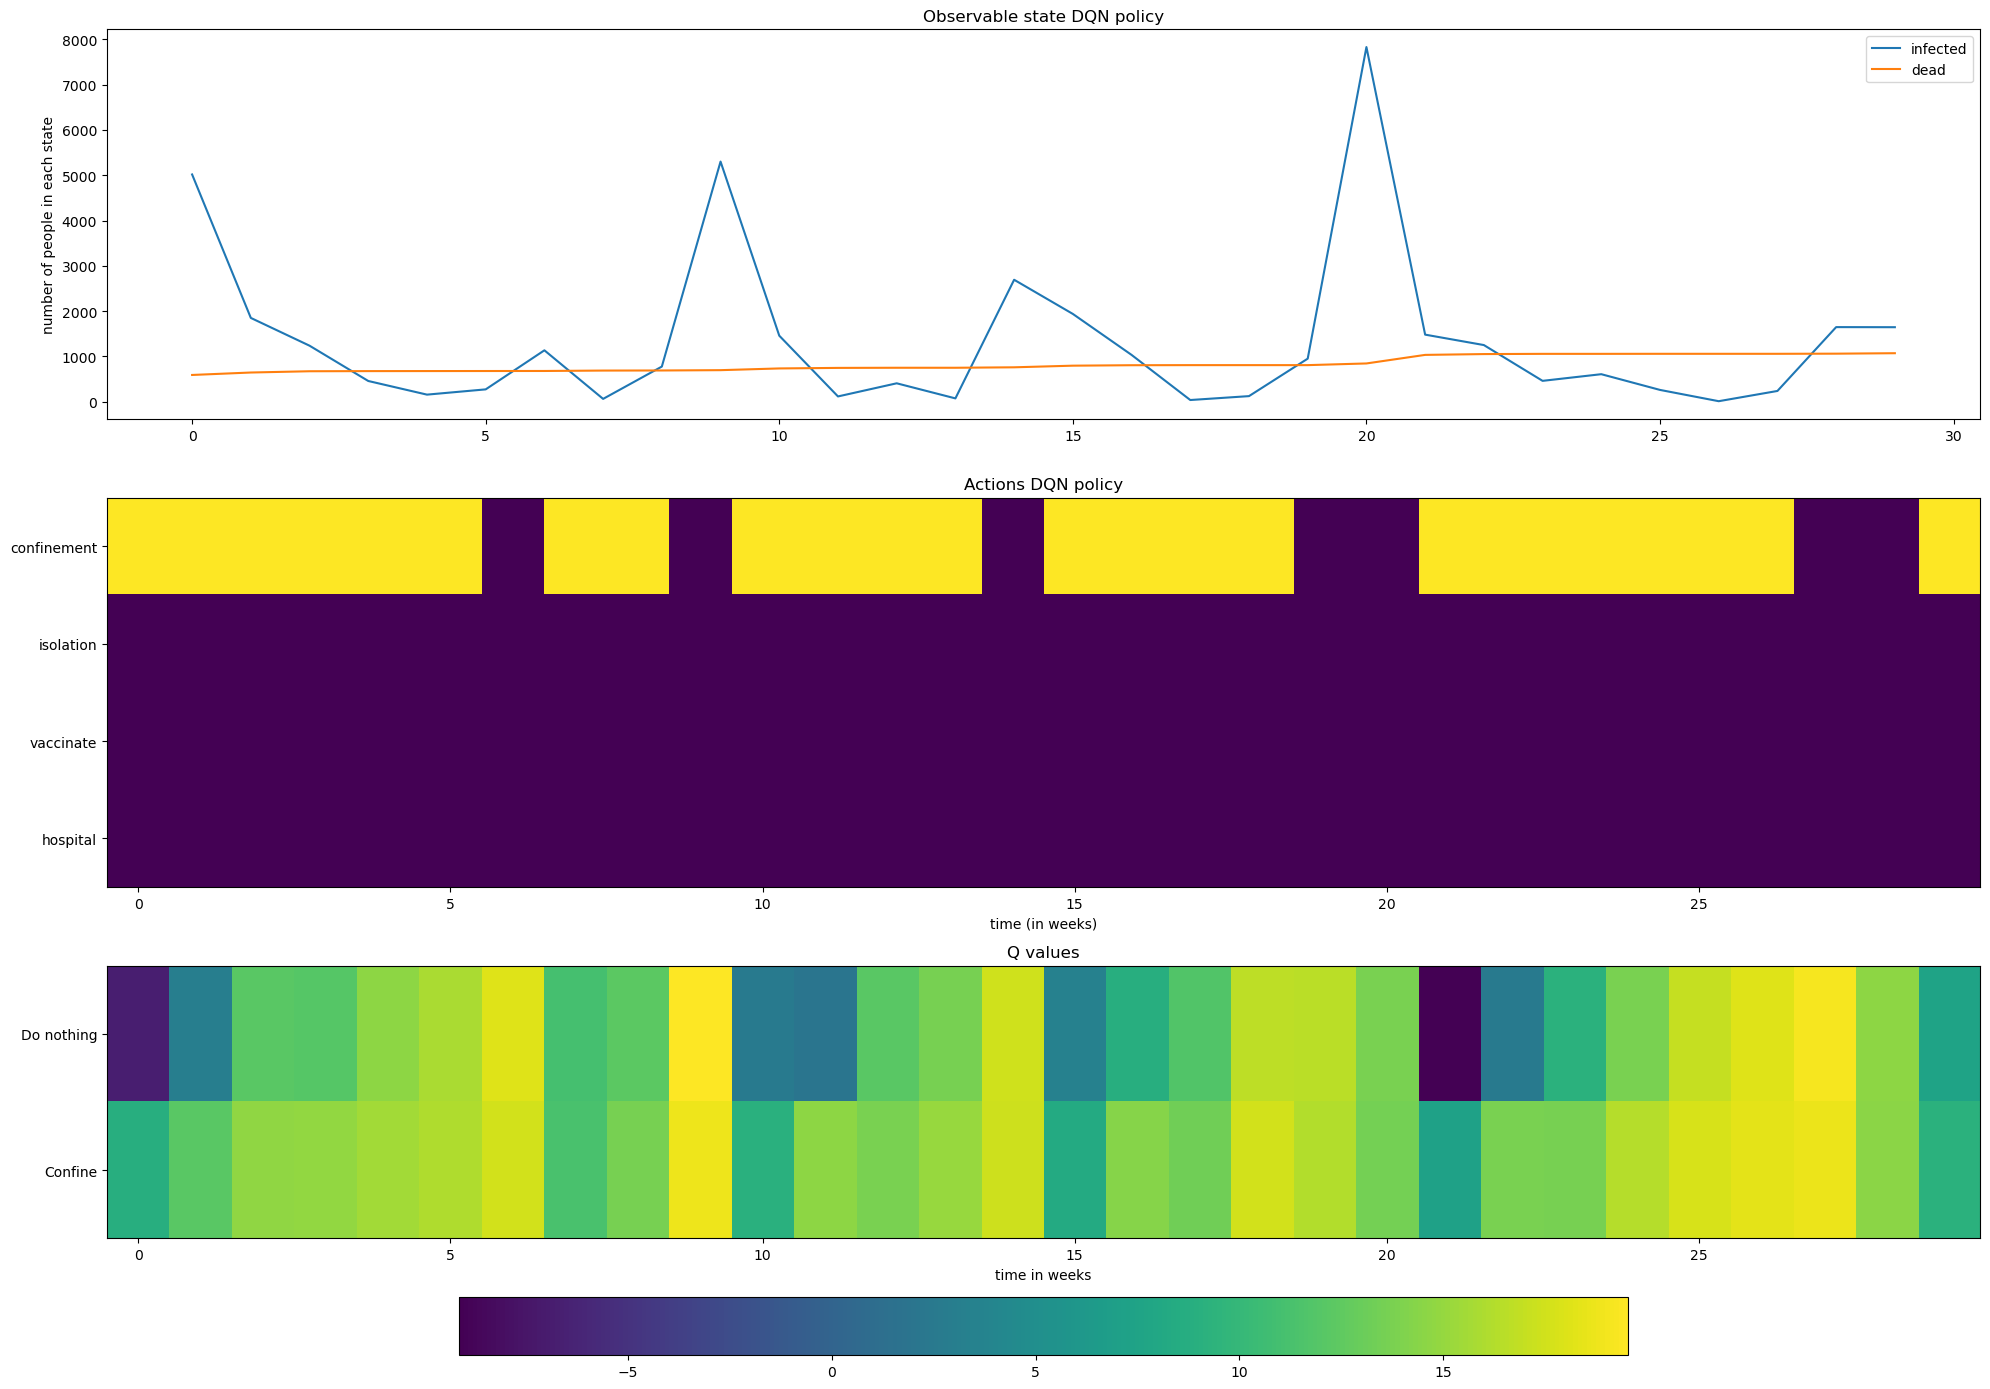

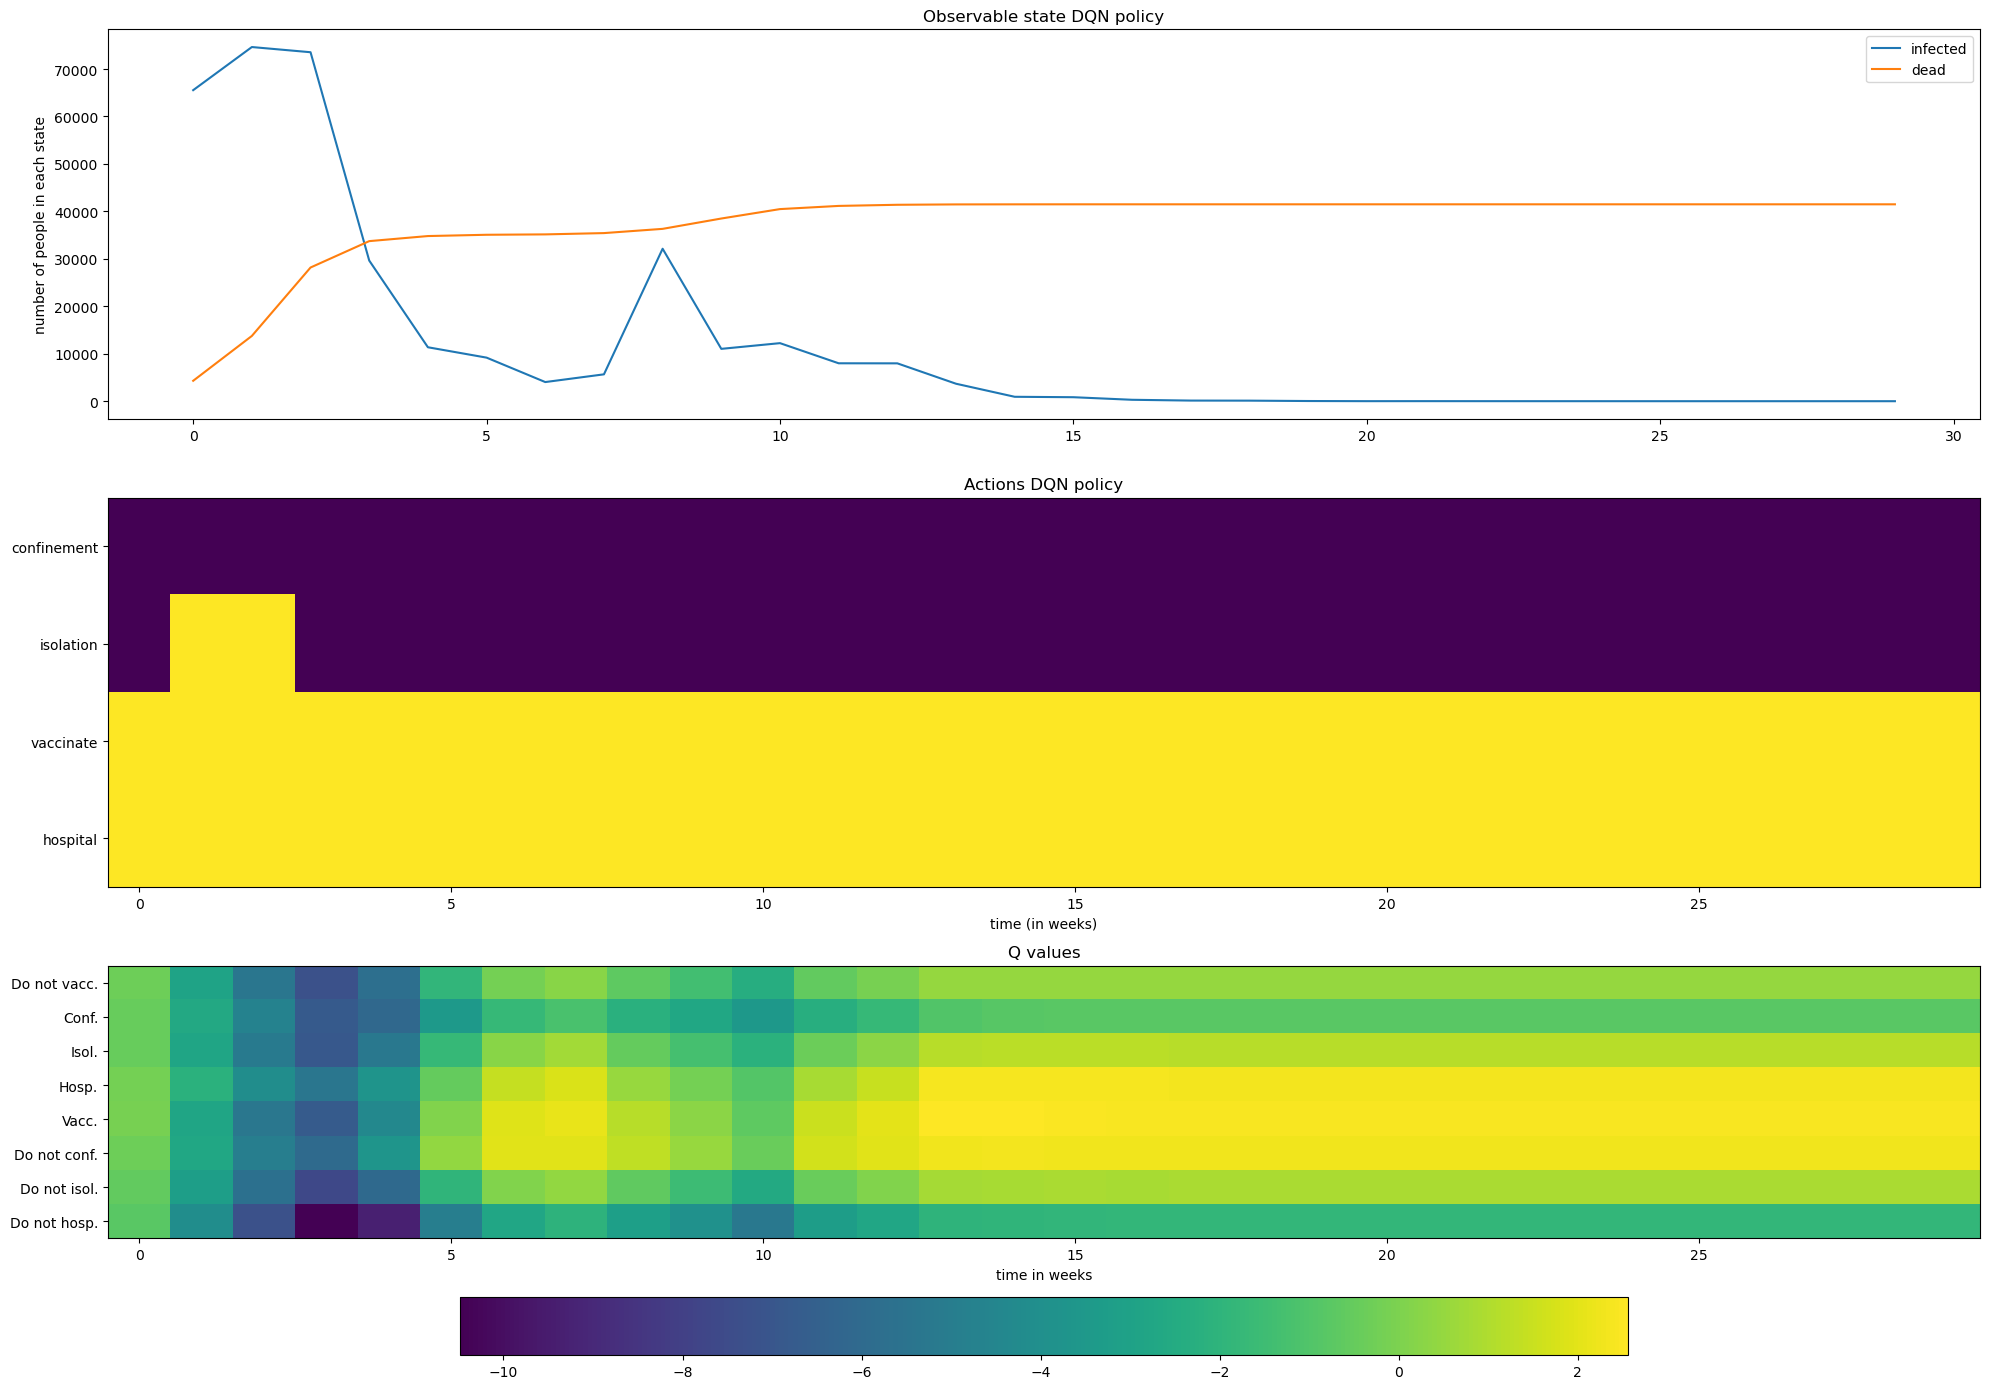

In [207]:
def plot_qvals(total,actions,qvals,action_labels, policy_name):
    fig,ax = plt.subplots(3,1,figsize=(20,14))

    [ax[0].plot(total[y]) for y in ['infected','dead']]
    ax[0].legend(['infected','dead'])
    ax[0].set_title(f'Observable state {policy_name}')
    ax[0].set_ylabel('number of people in each state')

    ax[1].imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax[1].set_title(f'Actions {policy_name}')
    ax[1].set_yticks([0,1,2,3])
    ax[1].set_yticklabels(list(actions.keys()))
    ax[1].set_xlabel('time (in weeks)')



    plt.title('Q values')
    im = ax[2].imshow(np.array([np.array(q.detach()).flatten() for q in qvals]).transpose(),aspect='auto')
    fig.colorbar(im, ax=ax[2],location='bottom')
    ax[2].set_xlabel('time in weeks')
    ax[2].set_yticks(range(len(action_labels)),action_labels)

    fig.tight_layout()
    plt.show()
plot_qvals(total_DQN, actions_DQN, qvals_DQN,['Do nothing','Confine'], "DQN policy")
plot_qvals(totalFACT, actionsFACT, qvalsFACT,['Do not vacc.','Conf.','Isol.','Hosp.','Vacc.','Do not conf.','Do not isol.','Do not hosp.'],"DQN policy")